In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from matplotlib import pyplot as plt
import pathlib
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Discriminator

In [2]:
# define the standalone discriminator model
def define_discriminator(in_shape=(256,256,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', 
                     input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, 
                  metrics=['accuracy'])
    return model

# Generator

In [3]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 32x32 image
    n_nodes = 128 * 64 * 64
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((64, 64, 128)))
    # upsample to 128x128
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), 
                              padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 256x256
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), 
                              padding='same', 
                              activation='tanh'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (8,8), activation='sigmoid', 
                     padding='same'))
    return model

# GAN

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# Support Functions

In [8]:
def process_path(file_path):
    image = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(image,channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [256,256])
    image = tf.reshape(image, [256,256,3])
    return image

# load and prepare training images
def load_real_samples():
    monet_images = pathlib.Path('/home/sean/.keras/datasets/monet_jpg')
    monet_images_list_ds = tf.data.Dataset.list_files(str(monet_images/'*'))
    monet_ds = []
    for i in monet_images_list_ds:
        monet_ds.append(process_path(i))

    trainX = tf.convert_to_tensor(monet_ds)
    plot_samples(trainX, title='Monet Images\n')
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # print('fake samples:,',X.shape)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y
 
# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

def plot_samples(input_array, rows=4, cols=5, title=''):
    '''
    Function to plot 256x256 pixel drawings that are stored in a numpy array.
    Specify how many rows and cols of pictures to display (default 4x5).  
    If the array contains less images than subplots selected, surplus subplots remain empty.
    '''    
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((256,256,3)), 
                             interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    plot_samples(x_fake, title='Monet Images\n')
    save_plot(x_fake, epoch)

# Training

In [9]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=15):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # print(dataset.shape[0])
    # print(n_batch)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            # print(X_real.shape)
            # print(X_fake.shape)
            X_real = X_real.reshape(X_fake.shape)
            X_fake = X_fake.reshape(X_fake.shape)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 1 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

DISCRIMINATOR
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 dropout_2 (Dropout)         (None, 128, 128, 64)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 dropout_3 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 2621

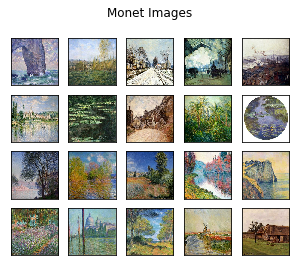

>1, 1/20, d=0.736, g=2.191
>1, 2/20, d=0.410, g=3.752
>1, 3/20, d=0.360, g=4.870
>1, 4/20, d=0.348, g=5.621
>1, 5/20, d=0.342, g=6.152
>1, 6/20, d=0.337, g=6.441
>1, 7/20, d=0.331, g=6.665
>1, 8/20, d=0.324, g=6.745
>1, 9/20, d=0.314, g=6.783
>1, 10/20, d=0.303, g=6.773
>1, 11/20, d=0.287, g=6.520
>1, 12/20, d=0.269, g=6.571
>1, 13/20, d=0.244, g=5.666
>1, 14/20, d=0.223, g=5.527
>1, 15/20, d=0.201, g=4.446
>1, 16/20, d=0.187, g=3.339
>1, 17/20, d=0.178, g=2.704
>1, 18/20, d=0.334, g=3.139
>1, 19/20, d=0.373, g=1.899
>1, 20/20, d=0.511, g=1.341
>Accuracy real: 100%, fake: 26%


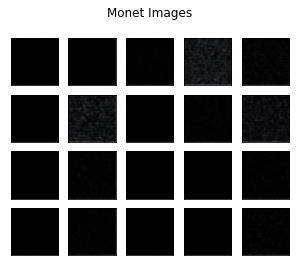

>2, 1/20, d=0.634, g=0.991
>2, 2/20, d=0.724, g=1.026
>2, 3/20, d=0.687, g=0.849
>2, 4/20, d=0.678, g=0.855
>2, 5/20, d=0.588, g=0.767
>2, 6/20, d=0.683, g=0.956
>2, 7/20, d=0.706, g=1.043
>2, 8/20, d=0.677, g=0.794
>2, 9/20, d=0.689, g=0.729
>2, 10/20, d=0.657, g=0.727
>2, 11/20, d=0.674, g=0.705
>2, 12/20, d=0.685, g=0.627
>2, 13/20, d=0.686, g=0.693
>2, 14/20, d=0.654, g=0.656
>2, 15/20, d=0.689, g=0.672
>2, 16/20, d=0.720, g=0.680
>2, 17/20, d=0.679, g=0.698
>2, 18/20, d=0.703, g=0.673
>2, 19/20, d=0.694, g=0.643
>2, 20/20, d=0.694, g=0.699
>Accuracy real: 95%, fake: 18%


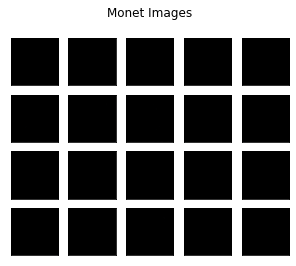

>3, 1/20, d=0.701, g=0.689
>3, 2/20, d=0.693, g=0.677
>3, 3/20, d=0.694, g=0.723
>3, 4/20, d=0.695, g=0.710
>3, 5/20, d=0.686, g=0.694
>3, 6/20, d=0.695, g=0.706
>3, 7/20, d=0.698, g=0.707
>3, 8/20, d=0.687, g=0.705
>3, 9/20, d=0.697, g=0.705
>3, 10/20, d=0.696, g=0.715
>3, 11/20, d=0.692, g=0.716
>3, 12/20, d=0.692, g=0.712
>3, 13/20, d=0.689, g=0.717
>3, 14/20, d=0.686, g=0.729
>3, 15/20, d=0.678, g=0.720
>3, 16/20, d=0.689, g=0.713
>3, 17/20, d=0.682, g=0.720
>3, 18/20, d=0.688, g=0.724
>3, 19/20, d=0.689, g=0.742
>3, 20/20, d=0.687, g=0.743
>Accuracy real: 0%, fake: 100%


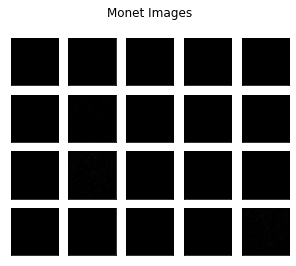

>4, 1/20, d=0.684, g=0.740
>4, 2/20, d=0.677, g=0.749
>4, 3/20, d=0.681, g=0.742
>4, 4/20, d=0.679, g=0.745
>4, 5/20, d=0.678, g=0.744
>4, 6/20, d=0.678, g=0.747
>4, 7/20, d=0.676, g=0.758
>4, 8/20, d=0.672, g=0.764
>4, 9/20, d=0.664, g=0.766
>4, 10/20, d=0.670, g=0.765
>4, 11/20, d=0.668, g=0.765
>4, 12/20, d=0.665, g=0.771
>4, 13/20, d=0.659, g=0.787
>4, 14/20, d=0.656, g=0.797
>4, 15/20, d=0.652, g=0.808
>4, 16/20, d=0.644, g=0.801
>4, 17/20, d=0.643, g=0.833
>4, 18/20, d=0.632, g=0.811
>4, 19/20, d=0.623, g=0.829
>4, 20/20, d=0.620, g=0.828
>Accuracy real: 93%, fake: 97%


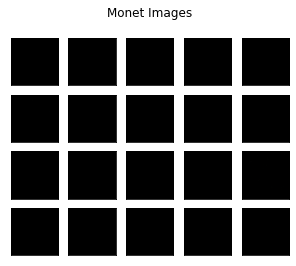

>5, 1/20, d=0.620, g=0.827
>5, 2/20, d=0.597, g=0.888
>5, 3/20, d=0.587, g=0.847
>5, 4/20, d=0.566, g=0.932
>5, 5/20, d=0.578, g=0.854
>5, 6/20, d=0.587, g=0.952
>5, 7/20, d=0.546, g=0.876
>5, 8/20, d=0.522, g=0.932
>5, 9/20, d=0.559, g=0.862
>5, 10/20, d=0.497, g=1.322
>5, 11/20, d=0.500, g=0.633
>5, 12/20, d=0.537, g=1.146
>5, 13/20, d=0.592, g=1.000
>5, 14/20, d=0.428, g=0.793
>5, 15/20, d=0.957, g=0.931
>5, 16/20, d=0.673, g=1.050
>5, 17/20, d=0.641, g=0.737
>5, 18/20, d=1.185, g=0.691
>5, 19/20, d=0.604, g=0.888
>5, 20/20, d=0.603, g=1.076
>Accuracy real: 92%, fake: 71%


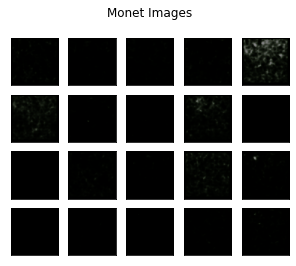

>6, 1/20, d=0.627, g=1.260
>6, 2/20, d=0.546, g=1.531
>6, 3/20, d=0.596, g=1.265
>6, 4/20, d=0.527, g=1.726
>6, 5/20, d=0.507, g=1.819
>6, 6/20, d=0.523, g=1.249
>6, 7/20, d=0.462, g=0.978
>6, 8/20, d=0.477, g=0.899
>6, 9/20, d=0.477, g=0.968
>6, 10/20, d=0.486, g=1.105
>6, 11/20, d=0.467, g=1.405
>6, 12/20, d=0.475, g=1.156
>6, 13/20, d=0.457, g=1.000
>6, 14/20, d=0.486, g=1.029
>6, 15/20, d=0.437, g=1.210
>6, 16/20, d=0.405, g=1.140
>6, 17/20, d=0.471, g=1.422
>6, 18/20, d=0.430, g=1.256
>6, 19/20, d=0.403, g=1.061
>6, 20/20, d=0.446, g=1.467
>Accuracy real: 97%, fake: 100%


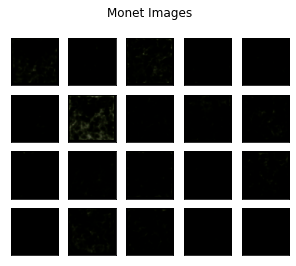

>7, 1/20, d=0.403, g=1.596
>7, 2/20, d=0.361, g=1.114
>7, 3/20, d=0.445, g=0.949
>7, 4/20, d=0.384, g=1.887
>7, 5/20, d=0.368, g=1.402
>7, 6/20, d=0.330, g=1.173
>7, 7/20, d=0.388, g=1.310
>7, 8/20, d=0.443, g=1.195
>7, 9/20, d=0.360, g=1.497
>7, 10/20, d=0.416, g=1.059
>7, 11/20, d=0.413, g=1.124
>7, 12/20, d=0.361, g=1.148
>7, 13/20, d=0.386, g=1.449
>7, 14/20, d=0.401, g=1.628
>7, 15/20, d=0.472, g=1.087
>7, 16/20, d=0.421, g=1.184
>7, 17/20, d=0.361, g=1.585
>7, 18/20, d=0.388, g=1.607
>7, 19/20, d=0.411, g=1.271
>7, 20/20, d=0.412, g=1.020
>Accuracy real: 100%, fake: 100%


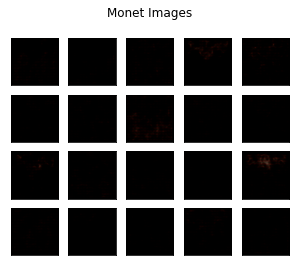

>8, 1/20, d=0.310, g=1.227
>8, 2/20, d=0.346, g=1.630
>8, 3/20, d=0.335, g=1.496
>8, 4/20, d=0.260, g=1.652
>8, 5/20, d=0.349, g=1.185
>8, 6/20, d=0.290, g=1.863
>8, 7/20, d=0.257, g=1.748
>8, 8/20, d=0.253, g=1.472
>8, 9/20, d=0.286, g=1.665
>8, 10/20, d=0.250, g=2.249
>8, 11/20, d=0.371, g=1.217
>8, 12/20, d=0.329, g=2.004
>8, 13/20, d=0.234, g=2.334
>8, 14/20, d=0.265, g=1.277
>8, 15/20, d=0.342, g=1.323
>8, 16/20, d=0.346, g=2.407
>8, 17/20, d=0.500, g=0.980
>8, 18/20, d=0.538, g=1.477
>8, 19/20, d=0.565, g=1.463
>8, 20/20, d=0.448, g=0.991
>Accuracy real: 98%, fake: 95%


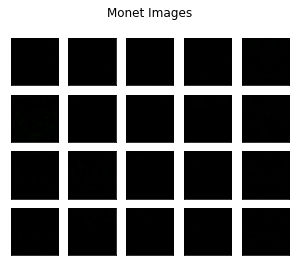

>9, 1/20, d=0.392, g=2.112
>9, 2/20, d=0.390, g=1.263
>9, 3/20, d=0.403, g=2.608
>9, 4/20, d=0.340, g=1.214
>9, 5/20, d=0.235, g=1.736
>9, 6/20, d=0.193, g=2.313
>9, 7/20, d=0.230, g=2.262
>9, 8/20, d=0.311, g=1.934
>9, 9/20, d=0.286, g=3.597
>9, 10/20, d=0.228, g=1.577
>9, 11/20, d=0.187, g=2.031
>9, 12/20, d=0.206, g=2.268
>9, 13/20, d=0.377, g=1.083
>9, 14/20, d=0.335, g=1.715
>9, 15/20, d=0.207, g=2.475
>9, 16/20, d=0.293, g=1.887
>9, 17/20, d=0.298, g=1.337
>9, 18/20, d=0.260, g=2.276
>9, 19/20, d=0.264, g=1.686
>9, 20/20, d=0.275, g=1.491
>Accuracy real: 99%, fake: 100%


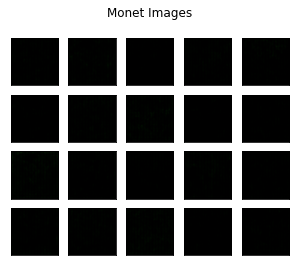

>10, 1/20, d=0.224, g=2.372
>10, 2/20, d=0.205, g=2.296
>10, 3/20, d=0.177, g=1.766
>10, 4/20, d=0.183, g=1.818
>10, 5/20, d=0.163, g=2.833
>10, 6/20, d=0.179, g=2.360
>10, 7/20, d=0.246, g=0.996
>10, 8/20, d=0.290, g=2.893
>10, 9/20, d=0.207, g=2.339
>10, 10/20, d=0.139, g=2.012
>10, 11/20, d=0.147, g=2.979
>10, 12/20, d=0.527, g=0.708
>10, 13/20, d=1.465, g=1.963
>10, 14/20, d=1.463, g=1.086
>10, 15/20, d=1.415, g=0.312
>10, 16/20, d=1.115, g=0.363
>10, 17/20, d=1.039, g=0.725
>10, 18/20, d=0.965, g=0.709
>10, 19/20, d=0.794, g=0.624
>10, 20/20, d=0.710, g=0.747
>Accuracy real: 98%, fake: 17%


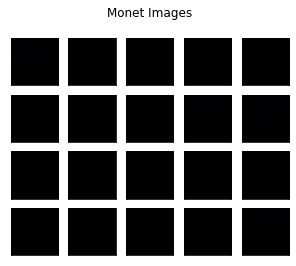

>11, 1/20, d=0.718, g=0.795
>11, 2/20, d=0.634, g=1.017
>11, 3/20, d=0.599, g=0.943
>11, 4/20, d=0.520, g=0.919
>11, 5/20, d=0.524, g=1.118
>11, 6/20, d=0.535, g=1.049
>11, 7/20, d=0.524, g=0.991
>11, 8/20, d=0.422, g=1.241
>11, 9/20, d=0.439, g=1.047
>11, 10/20, d=0.403, g=1.304
>11, 11/20, d=0.359, g=1.278
>11, 12/20, d=0.368, g=1.288
>11, 13/20, d=0.388, g=1.363
>11, 14/20, d=0.311, g=1.599
>11, 15/20, d=0.271, g=1.388
>11, 16/20, d=0.358, g=1.106
>11, 17/20, d=0.310, g=1.872
>11, 18/20, d=0.222, g=2.083
>11, 19/20, d=0.207, g=1.815
>11, 20/20, d=0.225, g=1.553
>Accuracy real: 100%, fake: 100%


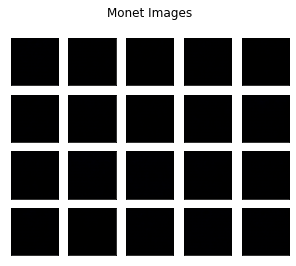

>12, 1/20, d=0.268, g=1.481
>12, 2/20, d=0.211, g=1.985
>12, 3/20, d=0.256, g=1.489
>12, 4/20, d=0.245, g=1.767
>12, 5/20, d=0.155, g=2.683
>12, 6/20, d=0.177, g=1.845
>12, 7/20, d=0.223, g=1.306
>12, 8/20, d=0.412, g=2.515
>12, 9/20, d=0.914, g=1.558
>12, 10/20, d=0.787, g=1.556
>12, 11/20, d=0.450, g=1.287
>12, 12/20, d=0.386, g=2.008
>12, 13/20, d=0.617, g=1.185
>12, 14/20, d=0.459, g=1.668
>12, 15/20, d=0.347, g=1.032
>12, 16/20, d=0.391, g=1.844
>12, 17/20, d=0.380, g=1.146
>12, 18/20, d=0.337, g=1.369
>12, 19/20, d=0.375, g=1.549
>12, 20/20, d=0.370, g=1.148
>Accuracy real: 99%, fake: 97%


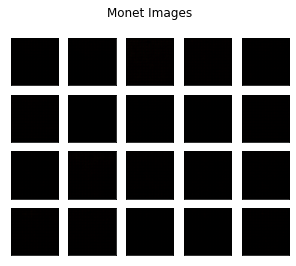

>13, 1/20, d=0.340, g=2.354
>13, 2/20, d=0.519, g=0.510
>13, 3/20, d=0.662, g=1.897
>13, 4/20, d=0.641, g=1.220
>13, 5/20, d=0.828, g=0.677
>13, 6/20, d=0.810, g=1.033
>13, 7/20, d=0.777, g=0.848
>13, 8/20, d=0.638, g=0.906
>13, 9/20, d=0.552, g=0.835
>13, 10/20, d=0.476, g=0.867
>13, 11/20, d=0.526, g=1.554
>13, 12/20, d=0.523, g=0.986
>13, 13/20, d=0.457, g=0.895
>13, 14/20, d=0.450, g=1.376
>13, 15/20, d=0.435, g=1.206
>13, 16/20, d=0.509, g=1.247
>13, 17/20, d=0.502, g=1.297
>13, 18/20, d=0.757, g=0.332
>13, 19/20, d=0.830, g=0.852
>13, 20/20, d=0.740, g=1.087
>Accuracy real: 4%, fake: 77%


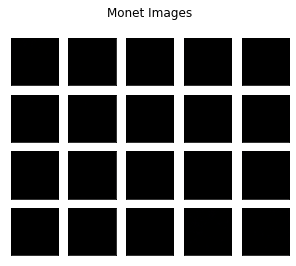

>14, 1/20, d=0.732, g=0.630
>14, 2/20, d=0.729, g=0.760
>14, 3/20, d=0.744, g=0.760
>14, 4/20, d=0.664, g=0.731
>14, 5/20, d=0.649, g=0.920
>14, 6/20, d=0.626, g=0.640
>14, 7/20, d=0.642, g=1.000
>14, 8/20, d=0.537, g=1.280
>14, 9/20, d=0.555, g=0.787
>14, 10/20, d=0.516, g=0.922
>14, 11/20, d=0.602, g=1.249
>14, 12/20, d=0.620, g=0.833
>14, 13/20, d=0.568, g=0.740
>14, 14/20, d=0.641, g=1.179
>14, 15/20, d=0.647, g=0.782
>14, 16/20, d=0.670, g=1.028
>14, 17/20, d=0.692, g=0.845
>14, 18/20, d=0.674, g=0.721
>14, 19/20, d=0.795, g=0.572
>14, 20/20, d=0.789, g=0.890
>Accuracy real: 0%, fake: 58%


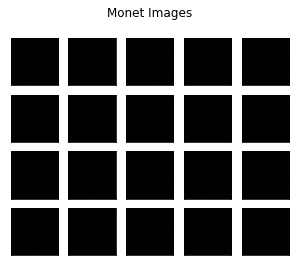

>15, 1/20, d=0.814, g=0.570
>15, 2/20, d=0.757, g=0.740
>15, 3/20, d=0.700, g=1.106
>15, 4/20, d=0.628, g=0.888
>15, 5/20, d=0.556, g=0.953
>15, 6/20, d=0.621, g=0.915
>15, 7/20, d=0.558, g=1.327
>15, 8/20, d=0.598, g=1.021
>15, 9/20, d=0.614, g=0.631
>15, 10/20, d=0.727, g=0.965
>15, 11/20, d=0.605, g=0.992
>15, 12/20, d=0.723, g=0.561
>15, 13/20, d=0.767, g=0.750
>15, 14/20, d=0.643, g=0.870
>15, 15/20, d=0.709, g=0.537
>15, 16/20, d=0.706, g=0.927
>15, 17/20, d=0.648, g=0.921
>15, 18/20, d=0.663, g=0.820
>15, 19/20, d=0.664, g=0.605
>15, 20/20, d=0.637, g=1.095
>Accuracy real: 55%, fake: 100%


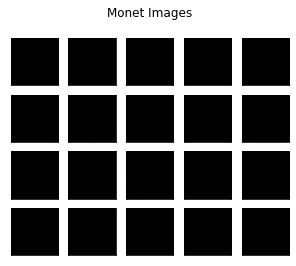

>16, 1/20, d=0.618, g=0.884
>16, 2/20, d=0.641, g=0.744
>16, 3/20, d=0.547, g=0.872
>16, 4/20, d=0.628, g=0.869
>16, 5/20, d=0.607, g=0.862
>16, 6/20, d=0.638, g=0.747
>16, 7/20, d=0.676, g=0.681
>16, 8/20, d=0.698, g=0.964
>16, 9/20, d=0.727, g=0.769
>16, 10/20, d=0.736, g=0.597
>16, 11/20, d=0.663, g=0.780
>16, 12/20, d=0.680, g=0.902
>16, 13/20, d=0.593, g=0.866
>16, 14/20, d=0.556, g=0.842
>16, 15/20, d=0.638, g=0.974
>16, 16/20, d=0.588, g=0.898
>16, 17/20, d=0.630, g=0.696
>16, 18/20, d=0.627, g=0.956
>16, 19/20, d=0.605, g=0.758
>16, 20/20, d=0.596, g=0.773
>Accuracy real: 71%, fake: 58%


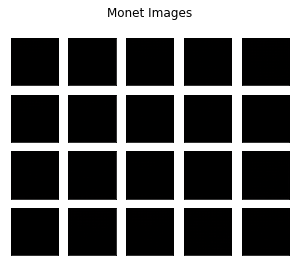

>17, 1/20, d=0.671, g=0.759
>17, 2/20, d=0.633, g=0.760
>17, 3/20, d=0.604, g=0.860
>17, 4/20, d=0.631, g=0.670
>17, 5/20, d=0.651, g=0.862
>17, 6/20, d=0.623, g=0.890
>17, 7/20, d=0.611, g=0.751
>17, 8/20, d=0.574, g=0.905
>17, 9/20, d=0.565, g=0.969
>17, 10/20, d=0.612, g=0.747
>17, 11/20, d=0.642, g=0.835
>17, 12/20, d=0.612, g=1.042
>17, 13/20, d=0.638, g=0.626
>17, 14/20, d=0.642, g=0.776
>17, 15/20, d=0.620, g=0.895
>17, 16/20, d=0.616, g=0.697
>17, 17/20, d=0.674, g=0.792
>17, 18/20, d=0.678, g=0.734
>17, 19/20, d=0.659, g=0.629
>17, 20/20, d=0.643, g=0.847
>Accuracy real: 74%, fake: 90%


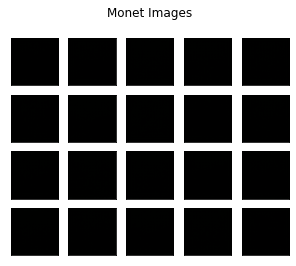

>18, 1/20, d=0.609, g=0.860
>18, 2/20, d=0.602, g=0.778
>18, 3/20, d=0.586, g=0.924
>18, 4/20, d=0.631, g=0.774
>18, 5/20, d=0.619, g=0.786
>18, 6/20, d=0.653, g=0.791
>18, 7/20, d=0.605, g=0.666
>18, 8/20, d=0.672, g=0.948
>18, 9/20, d=0.676, g=0.639
>18, 10/20, d=0.641, g=0.790
>18, 11/20, d=0.677, g=0.998
>18, 12/20, d=0.707, g=0.703
>18, 13/20, d=0.690, g=0.861
>18, 14/20, d=0.640, g=0.737
>18, 15/20, d=0.635, g=0.895
>18, 16/20, d=0.601, g=0.719
>18, 17/20, d=0.685, g=0.980
>18, 18/20, d=0.659, g=0.737
>18, 19/20, d=0.652, g=0.807
>18, 20/20, d=0.609, g=1.063
>Accuracy real: 17%, fake: 100%


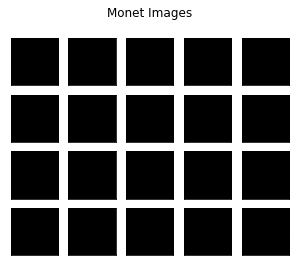

>19, 1/20, d=0.664, g=0.545
>19, 2/20, d=0.641, g=0.966
>19, 3/20, d=0.613, g=0.849
>19, 4/20, d=0.576, g=0.759
>19, 5/20, d=0.638, g=0.883
>19, 6/20, d=0.638, g=0.793
>19, 7/20, d=0.619, g=0.800
>19, 8/20, d=0.691, g=0.714
>19, 9/20, d=0.727, g=0.939
>19, 10/20, d=0.706, g=0.618
>19, 11/20, d=0.704, g=0.962
>19, 12/20, d=0.723, g=0.708
>19, 13/20, d=0.693, g=0.705
>19, 14/20, d=0.636, g=0.921
>19, 15/20, d=0.595, g=0.596
>19, 16/20, d=0.667, g=0.915
>19, 17/20, d=0.641, g=0.940
>19, 18/20, d=0.613, g=0.671
>19, 19/20, d=0.682, g=0.925
>19, 20/20, d=0.660, g=0.757
>Accuracy real: 79%, fake: 61%


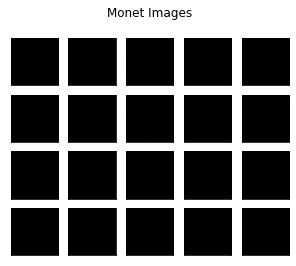

>20, 1/20, d=0.663, g=0.655
>20, 2/20, d=0.648, g=0.915
>20, 3/20, d=0.724, g=0.608
>20, 4/20, d=0.673, g=0.859
>20, 5/20, d=0.699, g=0.679
>20, 6/20, d=0.668, g=0.577
>20, 7/20, d=0.724, g=0.888
>20, 8/20, d=0.686, g=0.711
>20, 9/20, d=0.661, g=0.773
>20, 10/20, d=0.667, g=0.766
>20, 11/20, d=0.673, g=0.707
>20, 12/20, d=0.619, g=0.769
>20, 13/20, d=0.670, g=0.981
>20, 14/20, d=0.677, g=0.565
>20, 15/20, d=0.633, g=0.995
>20, 16/20, d=0.607, g=0.822
>20, 17/20, d=0.608, g=0.630
>20, 18/20, d=0.648, g=0.971
>20, 19/20, d=0.670, g=0.793
>20, 20/20, d=0.653, g=0.776
>Accuracy real: 88%, fake: 43%


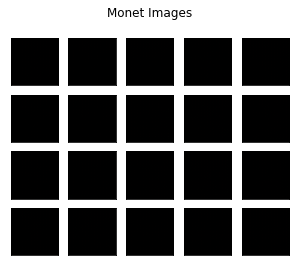

>21, 1/20, d=0.658, g=0.930
>21, 2/20, d=0.662, g=0.543
>21, 3/20, d=0.738, g=1.027
>21, 4/20, d=0.720, g=0.633
>21, 5/20, d=0.657, g=0.711
>21, 6/20, d=0.636, g=0.934
>21, 7/20, d=0.650, g=0.767
>21, 8/20, d=0.638, g=0.897
>21, 9/20, d=0.563, g=1.004
>21, 10/20, d=0.578, g=0.832
>21, 11/20, d=0.586, g=0.889
>21, 12/20, d=0.611, g=1.009
>21, 13/20, d=0.613, g=0.767
>21, 14/20, d=0.657, g=0.923
>21, 15/20, d=0.661, g=0.809
>21, 16/20, d=0.611, g=0.817
>21, 17/20, d=0.650, g=0.779
>21, 18/20, d=0.611, g=0.808
>21, 19/20, d=0.643, g=0.783
>21, 20/20, d=0.640, g=0.688
>Accuracy real: 97%, fake: 48%


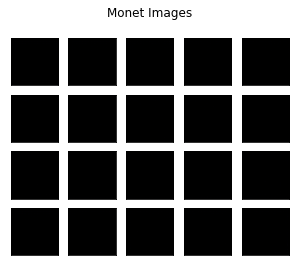

>22, 1/20, d=0.675, g=1.088
>22, 2/20, d=0.634, g=0.652
>22, 3/20, d=0.607, g=0.874
>22, 4/20, d=0.622, g=0.925
>22, 5/20, d=0.554, g=0.952
>22, 6/20, d=0.565, g=0.868
>22, 7/20, d=0.628, g=0.675
>22, 8/20, d=0.592, g=1.043
>22, 9/20, d=0.586, g=0.811
>22, 10/20, d=0.600, g=0.766
>22, 11/20, d=0.609, g=0.868
>22, 12/20, d=0.610, g=0.688
>22, 13/20, d=0.564, g=1.067
>22, 14/20, d=0.594, g=0.784
>22, 15/20, d=0.696, g=0.960
>22, 16/20, d=0.474, g=1.025
>22, 17/20, d=0.433, g=1.249
>22, 18/20, d=0.401, g=1.432
>22, 19/20, d=0.528, g=1.618
>22, 20/20, d=0.369, g=2.061
>Accuracy real: 100%, fake: 100%


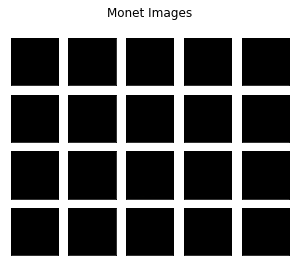

>23, 1/20, d=0.179, g=1.546
>23, 2/20, d=0.119, g=2.371
>23, 3/20, d=0.105, g=2.744
>23, 4/20, d=0.076, g=3.017
>23, 5/20, d=0.107, g=2.614
>23, 6/20, d=0.615, g=2.589
>23, 7/20, d=0.352, g=2.925
>23, 8/20, d=0.609, g=1.482
>23, 9/20, d=1.209, g=0.556
>23, 10/20, d=0.743, g=0.859
>23, 11/20, d=0.634, g=1.617
>23, 12/20, d=0.480, g=0.663
>23, 13/20, d=0.562, g=1.338
>23, 14/20, d=0.517, g=1.221
>23, 15/20, d=0.531, g=0.980
>23, 16/20, d=0.511, g=1.188
>23, 17/20, d=0.506, g=1.245
>23, 18/20, d=0.608, g=0.758
>23, 19/20, d=0.592, g=1.037
>23, 20/20, d=0.611, g=0.866
>Accuracy real: 83%, fake: 55%


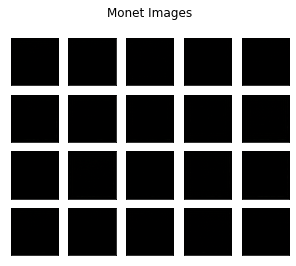

>24, 1/20, d=0.539, g=0.971
>24, 2/20, d=0.685, g=0.860
>24, 3/20, d=0.730, g=0.662
>24, 4/20, d=0.788, g=0.674
>24, 5/20, d=0.795, g=0.854
>24, 6/20, d=0.823, g=0.533
>24, 7/20, d=0.812, g=0.704
>24, 8/20, d=0.765, g=0.777
>24, 9/20, d=0.671, g=0.803
>24, 10/20, d=0.660, g=0.776
>24, 11/20, d=0.654, g=0.954
>24, 12/20, d=0.599, g=0.763
>24, 13/20, d=0.648, g=0.851
>24, 14/20, d=0.572, g=1.131
>24, 15/20, d=0.671, g=0.682
>24, 16/20, d=0.624, g=0.987
>24, 17/20, d=0.608, g=0.811
>24, 18/20, d=0.640, g=0.520
>24, 19/20, d=0.685, g=1.286
>24, 20/20, d=0.621, g=0.701
>Accuracy real: 87%, fake: 16%


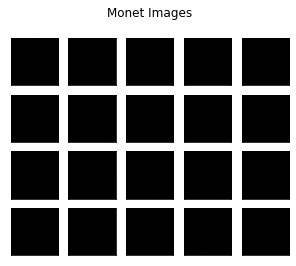

>25, 1/20, d=0.645, g=0.664
>25, 2/20, d=0.641, g=1.070
>25, 3/20, d=0.722, g=0.668
>25, 4/20, d=0.688, g=0.726
>25, 5/20, d=0.698, g=0.876
>25, 6/20, d=0.700, g=0.701
>25, 7/20, d=0.671, g=0.647
>25, 8/20, d=0.654, g=1.048
>25, 9/20, d=0.695, g=0.636
>25, 10/20, d=0.630, g=0.903
>25, 11/20, d=0.573, g=1.121
>25, 12/20, d=0.575, g=0.769
>25, 13/20, d=0.621, g=0.844
>25, 14/20, d=0.645, g=1.025
>25, 15/20, d=0.593, g=0.800
>25, 16/20, d=0.600, g=0.825
>25, 17/20, d=0.687, g=0.653
>25, 18/20, d=0.614, g=0.915
>25, 19/20, d=0.657, g=0.824
>25, 20/20, d=0.678, g=0.690
>Accuracy real: 82%, fake: 40%


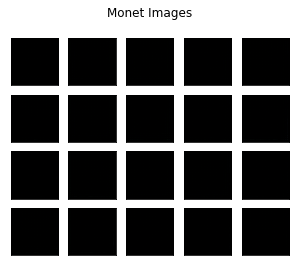

>26, 1/20, d=0.655, g=0.890
>26, 2/20, d=0.702, g=0.685
>26, 3/20, d=0.607, g=0.975
>26, 4/20, d=0.595, g=0.824
>26, 5/20, d=0.634, g=0.803
>26, 6/20, d=0.619, g=0.655
>26, 7/20, d=0.606, g=1.016
>26, 8/20, d=0.654, g=0.681
>26, 9/20, d=0.619, g=0.807
>26, 10/20, d=0.574, g=0.935
>26, 11/20, d=0.628, g=0.698
>26, 12/20, d=0.650, g=0.797
>26, 13/20, d=0.580, g=0.875
>26, 14/20, d=0.610, g=0.841
>26, 15/20, d=0.633, g=0.705
>26, 16/20, d=0.657, g=0.841
>26, 17/20, d=0.678, g=0.620
>26, 18/20, d=0.657, g=1.018
>26, 19/20, d=0.626, g=0.704
>26, 20/20, d=0.676, g=0.775
>Accuracy real: 72%, fake: 91%


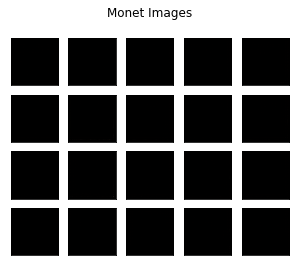

>27, 1/20, d=0.627, g=0.878
>27, 2/20, d=0.640, g=0.735
>27, 3/20, d=0.622, g=0.876
>27, 4/20, d=0.640, g=0.744
>27, 5/20, d=0.635, g=0.837
>27, 6/20, d=0.602, g=0.898
>27, 7/20, d=0.646, g=0.635
>27, 8/20, d=0.589, g=1.015
>27, 9/20, d=0.672, g=0.716
>27, 10/20, d=0.606, g=0.722
>27, 11/20, d=0.651, g=1.023
>27, 12/20, d=0.598, g=0.772
>27, 13/20, d=0.595, g=0.719
>27, 14/20, d=0.667, g=0.716
>27, 15/20, d=0.665, g=0.965
>27, 16/20, d=0.668, g=0.596
>27, 17/20, d=0.674, g=0.911
>27, 18/20, d=0.659, g=0.673
>27, 19/20, d=0.664, g=0.821
>27, 20/20, d=0.608, g=0.870
>Accuracy real: 51%, fake: 99%


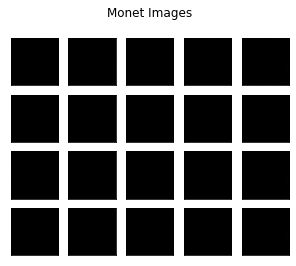

>28, 1/20, d=0.611, g=0.767
>28, 2/20, d=0.572, g=0.926
>28, 3/20, d=0.653, g=0.698
>28, 4/20, d=0.623, g=0.805
>28, 5/20, d=0.591, g=0.801
>28, 6/20, d=0.626, g=0.697
>28, 7/20, d=0.622, g=0.781
>28, 8/20, d=0.670, g=0.887
>28, 9/20, d=0.606, g=0.827
>28, 10/20, d=0.649, g=0.718
>28, 11/20, d=0.612, g=0.968
>28, 12/20, d=0.624, g=0.744
>28, 13/20, d=0.664, g=0.716
>28, 14/20, d=0.630, g=0.942
>28, 15/20, d=0.659, g=0.702
>28, 16/20, d=0.656, g=0.753
>28, 17/20, d=0.606, g=0.940
>28, 18/20, d=0.605, g=0.685
>28, 19/20, d=0.636, g=0.883
>28, 20/20, d=0.601, g=0.895
>Accuracy real: 67%, fake: 98%


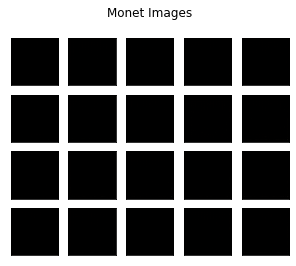

>29, 1/20, d=0.669, g=0.611
>29, 2/20, d=0.621, g=1.041
>29, 3/20, d=0.640, g=0.653
>29, 4/20, d=0.622, g=0.947
>29, 5/20, d=0.642, g=0.707
>29, 6/20, d=0.593, g=0.920
>29, 7/20, d=0.620, g=0.815
>29, 8/20, d=0.626, g=0.805
>29, 9/20, d=0.607, g=0.751
>29, 10/20, d=0.662, g=0.754
>29, 11/20, d=0.646, g=0.804
>29, 12/20, d=0.620, g=0.770
>29, 13/20, d=0.597, g=0.790
>29, 14/20, d=0.620, g=0.823
>29, 15/20, d=0.627, g=0.834
>29, 16/20, d=0.586, g=0.854
>29, 17/20, d=0.575, g=0.737
>29, 18/20, d=0.603, g=0.944
>29, 19/20, d=0.612, g=0.832
>29, 20/20, d=0.636, g=0.739
>Accuracy real: 90%, fake: 69%


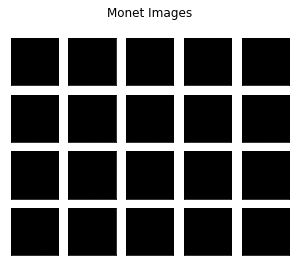

>30, 1/20, d=0.588, g=0.982
>30, 2/20, d=0.606, g=0.662
>30, 3/20, d=0.658, g=0.737
>30, 4/20, d=0.608, g=1.002
>30, 5/20, d=0.605, g=0.691
>30, 6/20, d=0.654, g=0.743
>30, 7/20, d=0.633, g=0.842
>30, 8/20, d=0.624, g=0.800
>30, 9/20, d=0.631, g=0.679
>30, 10/20, d=0.644, g=0.945
>30, 11/20, d=0.640, g=0.788
>30, 12/20, d=0.623, g=0.868
>30, 13/20, d=0.640, g=0.669
>30, 14/20, d=0.604, g=1.076
>30, 15/20, d=0.624, g=0.621
>30, 16/20, d=0.602, g=0.796
>30, 17/20, d=0.606, g=0.913
>30, 18/20, d=0.604, g=0.835
>30, 19/20, d=0.570, g=0.893
>30, 20/20, d=0.592, g=0.847
>Accuracy real: 66%, fake: 93%


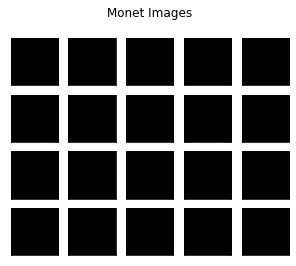

>31, 1/20, d=0.591, g=0.689
>31, 2/20, d=0.589, g=0.938
>31, 3/20, d=0.617, g=0.642
>31, 4/20, d=0.608, g=0.880
>31, 5/20, d=0.612, g=0.776
>31, 6/20, d=0.632, g=0.715
>31, 7/20, d=0.656, g=0.860
>31, 8/20, d=0.614, g=0.769
>31, 9/20, d=0.650, g=0.638
>31, 10/20, d=0.635, g=1.043
>31, 11/20, d=0.643, g=0.538
>31, 12/20, d=0.596, g=0.853
>31, 13/20, d=0.601, g=0.757
>31, 14/20, d=0.650, g=0.656
>31, 15/20, d=0.607, g=0.985
>31, 16/20, d=0.592, g=0.781
>31, 17/20, d=0.606, g=0.748
>31, 18/20, d=0.607, g=0.971
>31, 19/20, d=0.607, g=0.757
>31, 20/20, d=0.633, g=0.811
>Accuracy real: 90%, fake: 74%


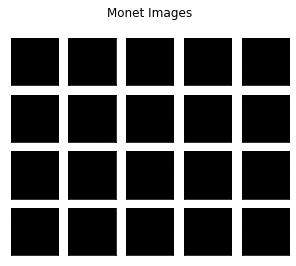

>32, 1/20, d=0.606, g=0.927
>32, 2/20, d=0.669, g=0.575
>32, 3/20, d=0.638, g=1.045
>32, 4/20, d=0.633, g=0.810
>32, 5/20, d=0.626, g=0.653
>32, 6/20, d=0.707, g=0.858
>32, 7/20, d=0.649, g=0.690
>32, 8/20, d=0.650, g=0.846
>32, 9/20, d=0.662, g=0.831
>32, 10/20, d=0.617, g=0.653
>32, 11/20, d=0.694, g=0.939
>32, 12/20, d=0.659, g=0.686
>32, 13/20, d=0.678, g=0.789
>32, 14/20, d=0.639, g=0.804
>32, 15/20, d=0.594, g=0.798
>32, 16/20, d=0.611, g=0.910
>32, 17/20, d=0.657, g=0.698
>32, 18/20, d=0.610, g=0.762
>32, 19/20, d=0.604, g=0.857
>32, 20/20, d=0.636, g=0.820
>Accuracy real: 51%, fake: 81%


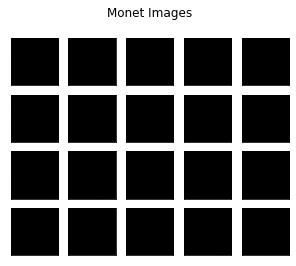

>33, 1/20, d=0.669, g=0.736
>33, 2/20, d=0.646, g=0.851
>33, 3/20, d=0.665, g=0.729
>33, 4/20, d=0.632, g=0.771
>33, 5/20, d=0.638, g=0.709
>33, 6/20, d=0.718, g=0.829
>33, 7/20, d=0.650, g=0.758
>33, 8/20, d=0.657, g=0.643
>33, 9/20, d=0.685, g=0.884
>33, 10/20, d=0.668, g=0.678
>33, 11/20, d=0.658, g=0.781
>33, 12/20, d=0.685, g=0.720
>33, 13/20, d=0.704, g=0.921
>33, 14/20, d=0.674, g=0.621
>33, 15/20, d=0.685, g=0.852
>33, 16/20, d=0.693, g=0.714
>33, 17/20, d=0.667, g=0.704
>33, 18/20, d=0.669, g=0.876
>33, 19/20, d=0.675, g=0.738
>33, 20/20, d=0.688, g=0.757
>Accuracy real: 59%, fake: 63%


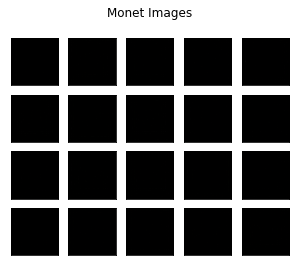

>34, 1/20, d=0.698, g=0.599
>34, 2/20, d=0.654, g=0.793
>34, 3/20, d=0.676, g=0.749
>34, 4/20, d=0.702, g=0.683
>34, 5/20, d=0.683, g=0.756
>34, 6/20, d=0.713, g=0.710
>34, 7/20, d=0.738, g=0.700
>34, 8/20, d=0.667, g=0.864
>34, 9/20, d=0.664, g=0.593
>34, 10/20, d=0.692, g=0.979
>34, 11/20, d=0.695, g=0.651
>34, 12/20, d=0.673, g=0.757
>34, 13/20, d=0.667, g=0.847
>34, 14/20, d=0.605, g=0.669
>34, 15/20, d=0.619, g=0.913
>34, 16/20, d=0.676, g=0.743
>34, 17/20, d=0.705, g=0.751
>34, 18/20, d=0.665, g=0.759
>34, 19/20, d=0.683, g=0.582
>34, 20/20, d=0.722, g=0.779
>Accuracy real: 15%, fake: 75%


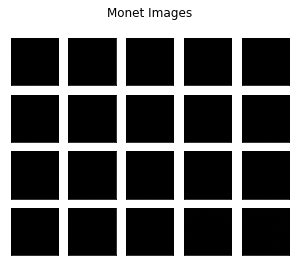

>35, 1/20, d=0.713, g=0.764
>35, 2/20, d=0.683, g=0.514
>35, 3/20, d=0.718, g=0.848
>35, 4/20, d=0.696, g=0.680
>35, 5/20, d=0.707, g=0.750
>35, 6/20, d=0.661, g=0.740
>35, 7/20, d=0.711, g=0.720
>35, 8/20, d=0.709, g=0.833
>35, 9/20, d=0.698, g=0.654
>35, 10/20, d=0.704, g=0.632
>35, 11/20, d=0.665, g=0.869
>35, 12/20, d=0.697, g=0.603
>35, 13/20, d=0.692, g=0.847
>35, 14/20, d=0.698, g=0.617
>35, 15/20, d=0.708, g=0.727
>35, 16/20, d=0.737, g=0.676
>35, 17/20, d=0.727, g=0.633
>35, 18/20, d=0.745, g=0.737
>35, 19/20, d=0.756, g=0.630
>35, 20/20, d=0.727, g=0.714
>Accuracy real: 9%, fake: 46%


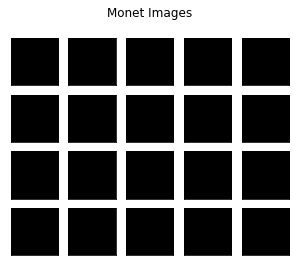

>36, 1/20, d=0.754, g=0.568
>36, 2/20, d=0.767, g=0.773
>36, 3/20, d=0.708, g=0.604
>36, 4/20, d=0.737, g=0.737
>36, 5/20, d=0.716, g=0.695
>36, 6/20, d=0.746, g=0.657
>36, 7/20, d=0.702, g=0.699
>36, 8/20, d=0.699, g=0.725
>36, 9/20, d=0.716, g=0.691
>36, 10/20, d=0.729, g=0.600
>36, 11/20, d=0.758, g=0.747
>36, 12/20, d=0.728, g=0.604
>36, 13/20, d=0.724, g=0.764
>36, 14/20, d=0.756, g=0.539
>36, 15/20, d=0.747, g=0.708
>36, 16/20, d=0.743, g=0.652
>36, 17/20, d=0.711, g=0.663
>36, 18/20, d=0.752, g=0.709
>36, 19/20, d=0.721, g=0.647
>36, 20/20, d=0.716, g=0.693
>Accuracy real: 30%, fake: 57%


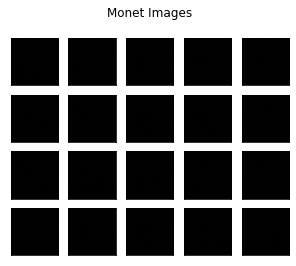

>37, 1/20, d=0.685, g=0.698
>37, 2/20, d=0.697, g=0.582
>37, 3/20, d=0.723, g=0.877
>37, 4/20, d=0.709, g=0.588
>37, 5/20, d=0.732, g=0.676
>37, 6/20, d=0.779, g=0.696
>37, 7/20, d=0.725, g=0.758
>37, 8/20, d=0.752, g=0.613
>37, 9/20, d=0.727, g=0.684
>37, 10/20, d=0.730, g=0.806
>37, 11/20, d=0.700, g=0.709
>37, 12/20, d=0.712, g=0.668
>37, 13/20, d=0.696, g=0.749
>37, 14/20, d=0.708, g=0.639
>37, 15/20, d=0.716, g=0.782
>37, 16/20, d=0.705, g=0.616
>37, 17/20, d=0.706, g=0.650
>37, 18/20, d=0.733, g=0.715
>37, 19/20, d=0.732, g=0.691
>37, 20/20, d=0.712, g=0.731
>Accuracy real: 20%, fake: 53%


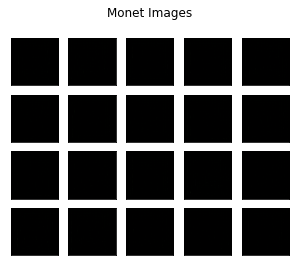

>38, 1/20, d=0.742, g=0.638
>38, 2/20, d=0.706, g=0.622
>38, 3/20, d=0.734, g=0.854
>38, 4/20, d=0.735, g=0.615
>38, 5/20, d=0.706, g=0.823
>38, 6/20, d=0.732, g=0.685
>38, 7/20, d=0.739, g=0.623
>38, 8/20, d=0.733, g=0.716
>38, 9/20, d=0.713, g=0.665
>38, 10/20, d=0.731, g=0.689
>38, 11/20, d=0.712, g=0.687
>38, 12/20, d=0.735, g=0.737
>38, 13/20, d=0.710, g=0.712
>38, 14/20, d=0.710, g=0.688
>38, 15/20, d=0.676, g=0.755
>38, 16/20, d=0.709, g=0.622
>38, 17/20, d=0.701, g=0.922
>38, 18/20, d=0.720, g=0.604
>38, 19/20, d=0.712, g=0.628
>38, 20/20, d=0.747, g=0.710
>Accuracy real: 6%, fake: 45%


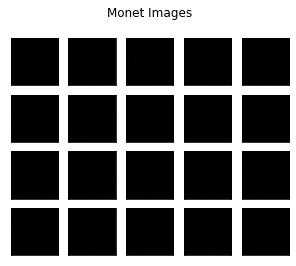

>39, 1/20, d=0.738, g=0.636
>39, 2/20, d=0.734, g=0.650
>39, 3/20, d=0.768, g=0.809
>39, 4/20, d=0.701, g=0.600
>39, 5/20, d=0.691, g=0.830
>39, 6/20, d=0.663, g=0.720
>39, 7/20, d=0.652, g=0.783
>39, 8/20, d=0.677, g=0.698
>39, 9/20, d=0.717, g=0.650
>39, 10/20, d=0.733, g=0.796
>39, 11/20, d=0.776, g=0.628
>39, 12/20, d=0.722, g=0.724
>39, 13/20, d=0.720, g=0.731
>39, 14/20, d=0.724, g=0.712
>39, 15/20, d=0.718, g=0.659
>39, 16/20, d=0.698, g=0.784
>39, 17/20, d=0.690, g=0.748
>39, 18/20, d=0.688, g=0.676
>39, 19/20, d=0.745, g=0.655
>39, 20/20, d=0.697, g=0.785
>Accuracy real: 3%, fake: 71%


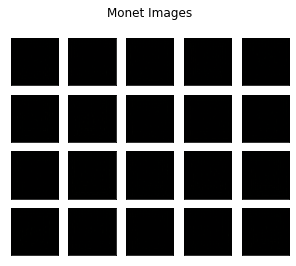

>40, 1/20, d=0.707, g=0.685
>40, 2/20, d=0.734, g=0.628
>40, 3/20, d=0.723, g=0.703
>40, 4/20, d=0.709, g=0.712
>40, 5/20, d=0.717, g=0.669
>40, 6/20, d=0.705, g=0.678
>40, 7/20, d=0.735, g=0.648
>40, 8/20, d=0.697, g=0.682
>40, 9/20, d=0.720, g=0.777
>40, 10/20, d=0.719, g=0.654
>40, 11/20, d=0.736, g=0.752
>40, 12/20, d=0.691, g=0.830
>40, 13/20, d=0.683, g=0.701
>40, 14/20, d=0.718, g=0.891
>40, 15/20, d=0.687, g=0.651
>40, 16/20, d=0.680, g=0.722
>40, 17/20, d=0.769, g=0.726
>40, 18/20, d=0.734, g=0.678
>40, 19/20, d=0.717, g=0.667
>40, 20/20, d=0.707, g=0.767
>Accuracy real: 41%, fake: 73%


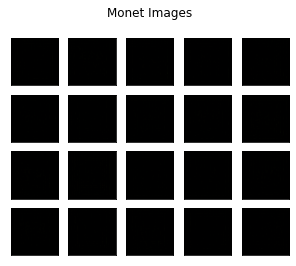

>41, 1/20, d=0.681, g=0.702
>41, 2/20, d=0.682, g=0.729
>41, 3/20, d=0.673, g=0.732
>41, 4/20, d=0.677, g=0.704
>41, 5/20, d=0.689, g=0.740
>41, 6/20, d=0.676, g=0.737
>41, 7/20, d=0.701, g=0.676
>41, 8/20, d=0.715, g=0.767
>41, 9/20, d=0.718, g=0.620
>41, 10/20, d=0.716, g=0.768
>41, 11/20, d=0.710, g=0.592
>41, 12/20, d=0.705, g=0.781
>41, 13/20, d=0.724, g=0.610
>41, 14/20, d=0.726, g=0.721
>41, 15/20, d=0.680, g=0.660
>41, 16/20, d=0.695, g=0.670
>41, 17/20, d=0.727, g=0.823
>41, 18/20, d=0.735, g=0.590
>41, 19/20, d=0.723, g=0.710
>41, 20/20, d=0.710, g=0.751
>Accuracy real: 5%, fake: 57%


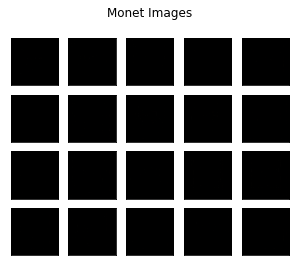

>42, 1/20, d=0.699, g=0.603
>42, 2/20, d=0.753, g=0.741
>42, 3/20, d=0.737, g=0.856
>42, 4/20, d=0.668, g=0.828
>42, 5/20, d=0.729, g=0.775
>42, 6/20, d=0.628, g=0.900
>42, 7/20, d=0.560, g=0.924
>42, 8/20, d=0.596, g=0.801
>42, 9/20, d=0.665, g=1.088
>42, 10/20, d=0.622, g=0.776
>42, 11/20, d=0.701, g=0.874
>42, 12/20, d=0.564, g=1.378
>42, 13/20, d=0.696, g=0.690
>42, 14/20, d=0.623, g=0.728
>42, 15/20, d=0.679, g=0.752
>42, 16/20, d=0.604, g=1.021
>42, 17/20, d=0.767, g=0.627
>42, 18/20, d=0.712, g=0.705
>42, 19/20, d=0.687, g=0.846
>42, 20/20, d=0.674, g=0.811
>Accuracy real: 35%, fake: 72%


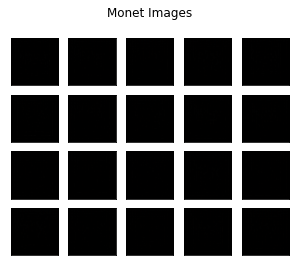

>43, 1/20, d=0.747, g=0.547
>43, 2/20, d=0.755, g=0.794
>43, 3/20, d=0.721, g=0.593
>43, 4/20, d=0.728, g=0.785
>43, 5/20, d=0.728, g=0.661
>43, 6/20, d=0.716, g=0.665
>43, 7/20, d=0.715, g=0.780
>43, 8/20, d=0.700, g=0.679
>43, 9/20, d=0.753, g=0.603
>43, 10/20, d=0.750, g=0.729
>43, 11/20, d=0.726, g=0.691
>43, 12/20, d=0.735, g=0.649
>43, 13/20, d=0.703, g=0.716
>43, 14/20, d=0.694, g=0.643
>43, 15/20, d=0.711, g=0.701
>43, 16/20, d=0.731, g=0.659
>43, 17/20, d=0.699, g=0.733
>43, 18/20, d=0.727, g=0.665
>43, 19/20, d=0.705, g=0.708
>43, 20/20, d=0.701, g=0.717
>Accuracy real: 33%, fake: 52%


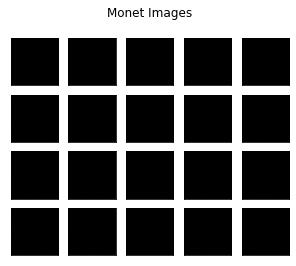

>44, 1/20, d=0.683, g=0.684
>44, 2/20, d=0.706, g=0.699
>44, 3/20, d=0.695, g=0.813
>44, 4/20, d=0.704, g=0.640
>44, 5/20, d=0.695, g=0.746
>44, 6/20, d=0.705, g=0.754
>44, 7/20, d=0.699, g=0.705
>44, 8/20, d=0.658, g=0.775
>44, 9/20, d=0.685, g=0.790
>44, 10/20, d=0.701, g=0.641
>44, 11/20, d=0.711, g=0.856
>44, 12/20, d=0.674, g=0.755
>44, 13/20, d=0.697, g=0.630
>44, 14/20, d=0.708, g=0.698
>44, 15/20, d=0.706, g=0.761
>44, 16/20, d=0.705, g=0.605
>44, 17/20, d=0.695, g=0.763
>44, 18/20, d=0.697, g=0.654
>44, 19/20, d=0.693, g=0.685
>44, 20/20, d=0.696, g=0.732
>Accuracy real: 40%, fake: 71%


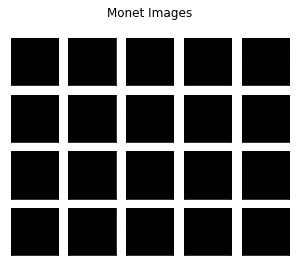

>45, 1/20, d=0.672, g=0.748
>45, 2/20, d=0.697, g=0.691
>45, 3/20, d=0.711, g=0.695
>45, 4/20, d=0.681, g=0.703
>45, 5/20, d=0.694, g=0.723
>45, 6/20, d=0.683, g=0.737
>45, 7/20, d=0.713, g=0.645
>45, 8/20, d=0.727, g=0.691
>45, 9/20, d=0.704, g=0.766
>45, 10/20, d=0.706, g=0.669
>45, 11/20, d=0.709, g=0.628
>45, 12/20, d=0.715, g=0.813
>45, 13/20, d=0.717, g=0.612
>45, 14/20, d=0.675, g=0.730
>45, 15/20, d=0.678, g=0.790
>45, 16/20, d=0.710, g=0.626
>45, 17/20, d=0.682, g=0.765
>45, 18/20, d=0.674, g=0.745
>45, 19/20, d=0.707, g=0.690
>45, 20/20, d=0.704, g=0.701
>Accuracy real: 65%, fake: 11%


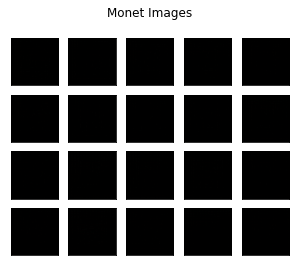

>46, 1/20, d=0.718, g=0.745
>46, 2/20, d=0.682, g=0.681
>46, 3/20, d=0.693, g=0.753
>46, 4/20, d=0.672, g=0.727
>46, 5/20, d=0.685, g=0.701
>46, 6/20, d=0.681, g=0.725
>46, 7/20, d=0.668, g=0.809
>46, 8/20, d=0.661, g=0.659
>46, 9/20, d=0.656, g=0.795
>46, 10/20, d=0.690, g=0.688
>46, 11/20, d=0.680, g=0.735
>46, 12/20, d=0.673, g=0.728
>46, 13/20, d=0.686, g=0.726
>46, 14/20, d=0.678, g=0.723
>46, 15/20, d=0.664, g=0.741
>46, 16/20, d=0.684, g=0.653
>46, 17/20, d=0.688, g=0.865
>46, 18/20, d=0.701, g=0.622
>46, 19/20, d=0.702, g=0.700
>46, 20/20, d=0.694, g=0.766
>Accuracy real: 40%, fake: 85%


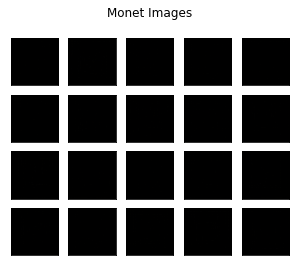

>47, 1/20, d=0.678, g=0.681
>47, 2/20, d=0.710, g=0.696
>47, 3/20, d=0.697, g=0.711
>47, 4/20, d=0.701, g=0.780
>47, 5/20, d=0.675, g=0.684
>47, 6/20, d=0.663, g=0.840
>47, 7/20, d=0.716, g=0.741
>47, 8/20, d=0.667, g=0.783
>47, 9/20, d=0.619, g=0.898
>47, 10/20, d=0.600, g=0.870
>47, 11/20, d=0.579, g=0.832
>47, 12/20, d=0.544, g=1.157
>47, 13/20, d=0.711, g=0.991
>47, 14/20, d=0.615, g=1.112
>47, 15/20, d=0.611, g=0.970
>47, 16/20, d=0.336, g=1.921
>47, 17/20, d=0.332, g=1.599
>47, 18/20, d=0.283, g=1.285
>47, 19/20, d=0.435, g=1.150
>47, 20/20, d=1.055, g=0.968
>Accuracy real: 17%, fake: 100%


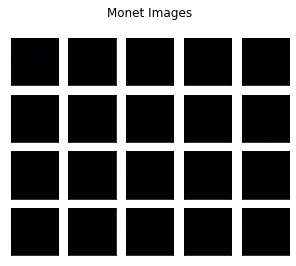

>48, 1/20, d=0.607, g=2.566
>48, 2/20, d=0.311, g=0.879
>48, 3/20, d=0.261, g=1.416
>48, 4/20, d=0.216, g=1.929
>48, 5/20, d=0.149, g=2.391
>48, 6/20, d=0.182, g=2.248
>48, 7/20, d=0.191, g=1.822
>48, 8/20, d=0.583, g=1.631
>48, 9/20, d=0.603, g=2.315
>48, 10/20, d=0.805, g=0.555
>48, 11/20, d=0.637, g=0.630
>48, 12/20, d=0.748, g=1.107
>48, 13/20, d=0.622, g=1.066
>48, 14/20, d=0.713, g=0.646
>48, 15/20, d=0.664, g=1.137
>48, 16/20, d=0.646, g=0.940
>48, 17/20, d=0.773, g=0.574
>48, 18/20, d=0.676, g=0.818
>48, 19/20, d=0.789, g=0.724
>48, 20/20, d=0.697, g=0.803
>Accuracy real: 22%, fake: 88%


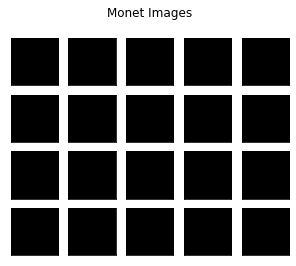

>49, 1/20, d=0.694, g=0.697
>49, 2/20, d=0.778, g=0.594
>49, 3/20, d=0.749, g=0.790
>49, 4/20, d=0.759, g=0.632
>49, 5/20, d=0.733, g=0.686
>49, 6/20, d=0.762, g=0.563
>49, 7/20, d=0.798, g=0.643
>49, 8/20, d=0.749, g=0.684
>49, 9/20, d=0.748, g=0.636
>49, 10/20, d=0.777, g=0.669
>49, 11/20, d=0.760, g=0.663
>49, 12/20, d=0.747, g=0.678
>49, 13/20, d=0.752, g=0.635
>49, 14/20, d=0.777, g=0.568
>49, 15/20, d=0.757, g=0.724
>49, 16/20, d=0.757, g=0.669
>49, 17/20, d=0.733, g=0.667
>49, 18/20, d=0.711, g=0.652
>49, 19/20, d=0.708, g=0.697
>49, 20/20, d=0.730, g=0.685
>Accuracy real: 39%, fake: 0%


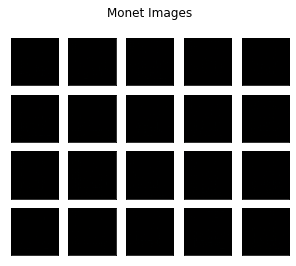

>50, 1/20, d=0.728, g=0.643
>50, 2/20, d=0.718, g=0.711
>50, 3/20, d=0.701, g=0.674
>50, 4/20, d=0.723, g=0.661
>50, 5/20, d=0.718, g=0.684
>50, 6/20, d=0.711, g=0.681
>50, 7/20, d=0.725, g=0.644
>50, 8/20, d=0.736, g=0.676
>50, 9/20, d=0.738, g=0.660
>50, 10/20, d=0.738, g=0.669
>50, 11/20, d=0.745, g=0.630
>50, 12/20, d=0.743, g=0.692
>50, 13/20, d=0.737, g=0.683
>50, 14/20, d=0.729, g=0.627
>50, 15/20, d=0.732, g=0.701
>50, 16/20, d=0.731, g=0.710
>50, 17/20, d=0.702, g=0.721
>50, 18/20, d=0.696, g=0.687
>50, 19/20, d=0.703, g=0.717
>50, 20/20, d=0.728, g=0.656
>Accuracy real: 80%, fake: 0%


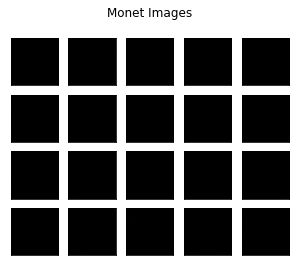

>51, 1/20, d=0.730, g=0.691
>51, 2/20, d=0.714, g=0.685
>51, 3/20, d=0.723, g=0.684
>51, 4/20, d=0.708, g=0.699
>51, 5/20, d=0.712, g=0.677
>51, 6/20, d=0.700, g=0.698
>51, 7/20, d=0.700, g=0.687
>51, 8/20, d=0.704, g=0.683
>51, 9/20, d=0.682, g=0.718
>51, 10/20, d=0.672, g=0.712
>51, 11/20, d=0.664, g=0.715
>51, 12/20, d=0.685, g=0.733
>51, 13/20, d=0.684, g=0.703
>51, 14/20, d=0.697, g=0.699
>51, 15/20, d=0.664, g=0.758
>51, 16/20, d=0.667, g=0.720
>51, 17/20, d=0.681, g=0.725
>51, 18/20, d=0.693, g=0.738
>51, 19/20, d=0.678, g=0.724
>51, 20/20, d=0.700, g=0.654
>Accuracy real: 90%, fake: 0%


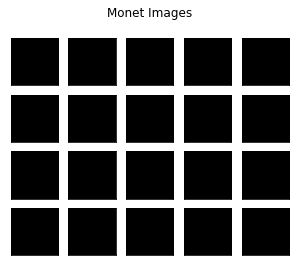

>52, 1/20, d=0.694, g=0.702
>52, 2/20, d=0.691, g=0.750
>52, 3/20, d=0.700, g=0.685
>52, 4/20, d=0.694, g=0.659
>52, 5/20, d=0.700, g=0.739
>52, 6/20, d=0.689, g=0.703
>52, 7/20, d=0.682, g=0.718
>52, 8/20, d=0.666, g=0.765
>52, 9/20, d=0.679, g=0.720
>52, 10/20, d=0.660, g=0.729
>52, 11/20, d=0.681, g=0.729
>52, 12/20, d=0.688, g=0.763
>52, 13/20, d=0.700, g=0.697
>52, 14/20, d=0.723, g=0.676
>52, 15/20, d=0.712, g=0.714
>52, 16/20, d=0.738, g=0.646
>52, 17/20, d=0.727, g=0.678
>52, 18/20, d=0.726, g=0.697
>52, 19/20, d=0.723, g=0.663
>52, 20/20, d=0.681, g=0.754
>Accuracy real: 47%, fake: 100%


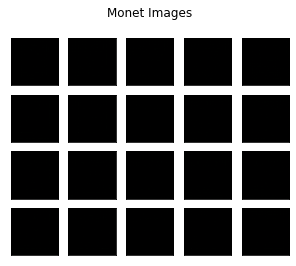

>53, 1/20, d=0.677, g=0.728
>53, 2/20, d=0.644, g=0.743
>53, 3/20, d=0.674, g=0.713
>53, 4/20, d=0.728, g=0.704
>53, 5/20, d=0.719, g=0.695
>53, 6/20, d=0.719, g=0.729
>53, 7/20, d=0.725, g=0.711
>53, 8/20, d=0.733, g=0.643
>53, 9/20, d=0.722, g=0.712
>53, 10/20, d=0.716, g=0.679
>53, 11/20, d=0.721, g=0.668
>53, 12/20, d=0.703, g=0.723
>53, 13/20, d=0.698, g=0.725
>53, 14/20, d=0.684, g=0.727
>53, 15/20, d=0.670, g=0.737
>53, 16/20, d=0.653, g=0.788
>53, 17/20, d=0.676, g=0.724
>53, 18/20, d=0.668, g=0.720
>53, 19/20, d=0.677, g=0.733
>53, 20/20, d=0.683, g=0.715
>Accuracy real: 68%, fake: 38%


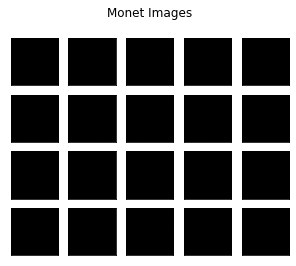

>54, 1/20, d=0.675, g=0.730
>54, 2/20, d=0.701, g=0.703
>54, 3/20, d=0.720, g=0.665
>54, 4/20, d=0.721, g=0.726
>54, 5/20, d=0.738, g=0.665
>54, 6/20, d=0.697, g=0.741
>54, 7/20, d=0.692, g=0.737
>54, 8/20, d=0.675, g=0.717
>54, 9/20, d=0.692, g=0.716
>54, 10/20, d=0.690, g=0.723
>54, 11/20, d=0.693, g=0.720
>54, 12/20, d=0.674, g=0.767
>54, 13/20, d=0.657, g=0.738
>54, 14/20, d=0.657, g=0.773
>54, 15/20, d=0.696, g=0.711
>54, 16/20, d=0.697, g=0.711
>54, 17/20, d=0.716, g=0.714
>54, 18/20, d=0.698, g=0.710
>54, 19/20, d=0.678, g=0.745
>54, 20/20, d=0.684, g=0.696
>Accuracy real: 62%, fake: 54%


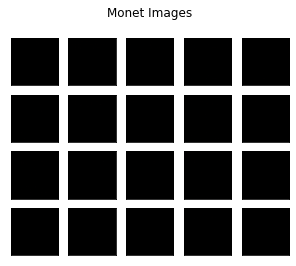

>55, 1/20, d=0.681, g=0.697
>55, 2/20, d=0.698, g=0.712
>55, 3/20, d=0.686, g=0.750
>55, 4/20, d=0.678, g=0.730
>55, 5/20, d=0.671, g=0.702
>55, 6/20, d=0.685, g=0.710
>55, 7/20, d=0.677, g=0.777
>55, 8/20, d=0.682, g=0.714
>55, 9/20, d=0.707, g=0.702
>55, 10/20, d=0.697, g=0.726
>55, 11/20, d=0.710, g=0.676
>55, 12/20, d=0.733, g=0.712
>55, 13/20, d=0.732, g=0.697
>55, 14/20, d=0.723, g=0.662
>55, 15/20, d=0.710, g=0.718
>55, 16/20, d=0.696, g=0.731
>55, 17/20, d=0.706, g=0.701
>55, 18/20, d=0.701, g=0.738
>55, 19/20, d=0.685, g=0.707
>55, 20/20, d=0.702, g=0.682
>Accuracy real: 72%, fake: 0%


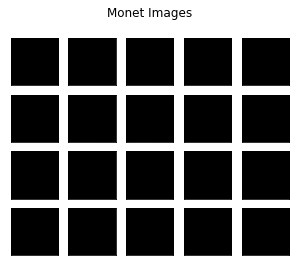

>56, 1/20, d=0.713, g=0.706
>56, 2/20, d=0.718, g=0.706
>56, 3/20, d=0.719, g=0.619
>56, 4/20, d=0.711, g=0.683
>56, 5/20, d=0.720, g=0.717
>56, 6/20, d=0.729, g=0.627
>56, 7/20, d=0.713, g=0.725
>56, 8/20, d=0.711, g=0.689
>56, 9/20, d=0.700, g=0.725
>56, 10/20, d=0.693, g=0.723
>56, 11/20, d=0.683, g=0.672
>56, 12/20, d=0.678, g=0.759
>56, 13/20, d=0.680, g=0.684
>56, 14/20, d=0.671, g=0.735
>56, 15/20, d=0.681, g=0.736
>56, 16/20, d=0.679, g=0.720
>56, 17/20, d=0.655, g=0.727
>56, 18/20, d=0.681, g=0.738
>56, 19/20, d=0.714, g=0.709
>56, 20/20, d=0.696, g=0.743
>Accuracy real: 7%, fake: 88%


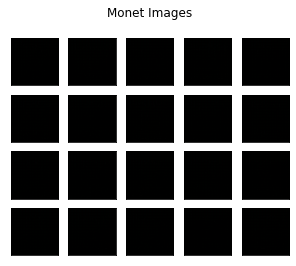

>57, 1/20, d=0.728, g=0.696
>57, 2/20, d=0.697, g=0.772
>57, 3/20, d=0.692, g=0.700
>57, 4/20, d=0.694, g=0.733
>57, 5/20, d=0.707, g=0.669
>57, 6/20, d=0.706, g=0.724
>57, 7/20, d=0.695, g=0.692
>57, 8/20, d=0.673, g=0.721
>57, 9/20, d=0.669, g=0.781
>57, 10/20, d=0.655, g=0.727
>57, 11/20, d=0.642, g=0.747
>57, 12/20, d=0.664, g=0.767
>57, 13/20, d=0.672, g=0.755
>57, 14/20, d=0.674, g=0.693
>57, 15/20, d=0.697, g=0.791
>57, 16/20, d=0.697, g=0.666
>57, 17/20, d=0.715, g=0.773
>57, 18/20, d=0.707, g=0.663
>57, 19/20, d=0.705, g=0.649
>57, 20/20, d=0.716, g=0.716
>Accuracy real: 2%, fake: 88%


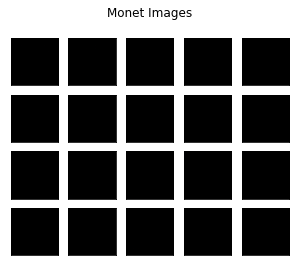

>58, 1/20, d=0.713, g=0.625
>58, 2/20, d=0.697, g=0.718
>58, 3/20, d=0.686, g=0.771
>58, 4/20, d=0.654, g=0.675
>58, 5/20, d=0.667, g=0.777
>58, 6/20, d=0.671, g=0.721
>58, 7/20, d=0.703, g=0.741
>58, 8/20, d=0.675, g=0.761
>58, 9/20, d=0.706, g=0.671
>58, 10/20, d=0.707, g=0.752
>58, 11/20, d=0.728, g=0.693
>58, 12/20, d=0.735, g=0.656
>58, 13/20, d=0.744, g=0.714
>58, 14/20, d=0.716, g=0.676
>58, 15/20, d=0.719, g=0.634
>58, 16/20, d=0.682, g=0.813
>58, 17/20, d=0.668, g=0.726
>58, 18/20, d=0.664, g=0.702
>58, 19/20, d=0.665, g=0.766
>58, 20/20, d=0.663, g=0.705
>Accuracy real: 96%, fake: 36%


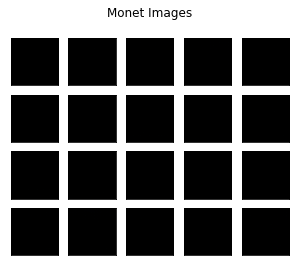

>59, 1/20, d=0.676, g=0.699
>59, 2/20, d=0.680, g=0.734
>59, 3/20, d=0.703, g=0.702
>59, 4/20, d=0.702, g=0.719
>59, 5/20, d=0.718, g=0.726
>59, 6/20, d=0.694, g=0.758
>59, 7/20, d=0.699, g=0.685
>59, 8/20, d=0.690, g=0.730
>59, 9/20, d=0.700, g=0.694
>59, 10/20, d=0.717, g=0.707
>59, 11/20, d=0.701, g=0.671
>59, 12/20, d=0.727, g=0.750
>59, 13/20, d=0.714, g=0.689
>59, 14/20, d=0.702, g=0.646
>59, 15/20, d=0.703, g=0.802
>59, 16/20, d=0.694, g=0.729
>59, 17/20, d=0.686, g=0.721
>59, 18/20, d=0.680, g=0.715
>59, 19/20, d=0.692, g=0.743
>59, 20/20, d=0.691, g=0.718
>Accuracy real: 15%, fake: 9%


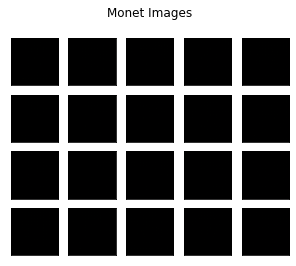

>60, 1/20, d=0.715, g=0.659
>60, 2/20, d=0.733, g=0.715
>60, 3/20, d=0.767, g=0.642
>60, 4/20, d=0.721, g=0.755
>60, 5/20, d=0.691, g=0.746
>60, 6/20, d=0.652, g=0.771
>60, 7/20, d=0.667, g=0.735
>60, 8/20, d=0.663, g=0.745
>60, 9/20, d=0.668, g=0.736
>60, 10/20, d=0.679, g=0.729
>60, 11/20, d=0.677, g=0.726
>60, 12/20, d=0.663, g=0.742
>60, 13/20, d=0.714, g=0.648
>60, 14/20, d=0.717, g=0.732
>60, 15/20, d=0.715, g=0.740
>60, 16/20, d=0.686, g=0.737
>60, 17/20, d=0.694, g=0.719
>60, 18/20, d=0.691, g=0.685
>60, 19/20, d=0.696, g=0.724
>60, 20/20, d=0.696, g=0.677
>Accuracy real: 97%, fake: 4%


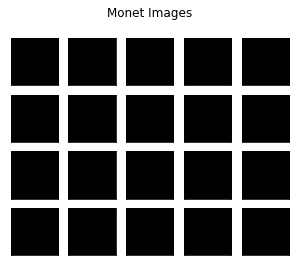

>61, 1/20, d=0.691, g=0.704
>61, 2/20, d=0.689, g=0.678
>61, 3/20, d=0.674, g=0.758
>61, 4/20, d=0.670, g=0.710
>61, 5/20, d=0.670, g=0.758
>61, 6/20, d=0.673, g=0.748
>61, 7/20, d=0.657, g=0.766
>61, 8/20, d=0.680, g=0.732
>61, 9/20, d=0.707, g=0.706
>61, 10/20, d=0.707, g=0.724
>61, 11/20, d=0.700, g=0.715
>61, 12/20, d=0.704, g=0.684
>61, 13/20, d=0.705, g=0.692
>61, 14/20, d=0.714, g=0.686
>61, 15/20, d=0.710, g=0.714
>61, 16/20, d=0.690, g=0.678
>61, 17/20, d=0.681, g=0.739
>61, 18/20, d=0.674, g=0.762
>61, 19/20, d=0.652, g=0.726
>61, 20/20, d=0.663, g=0.745
>Accuracy real: 86%, fake: 97%


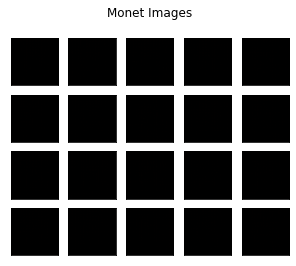

>62, 1/20, d=0.669, g=0.806
>62, 2/20, d=0.656, g=0.715
>62, 3/20, d=0.660, g=0.825
>62, 4/20, d=0.655, g=0.744
>62, 5/20, d=0.665, g=0.718
>62, 6/20, d=0.661, g=0.801
>62, 7/20, d=0.690, g=0.709
>62, 8/20, d=0.670, g=0.733
>62, 9/20, d=0.690, g=0.723
>62, 10/20, d=0.720, g=0.667
>62, 11/20, d=0.697, g=0.711
>62, 12/20, d=0.711, g=0.696
>62, 13/20, d=0.714, g=0.683
>62, 14/20, d=0.719, g=0.705
>62, 15/20, d=0.705, g=0.641
>62, 16/20, d=0.703, g=0.703
>62, 17/20, d=0.696, g=0.708
>62, 18/20, d=0.688, g=0.696
>62, 19/20, d=0.666, g=0.758
>62, 20/20, d=0.658, g=0.755
>Accuracy real: 81%, fake: 100%


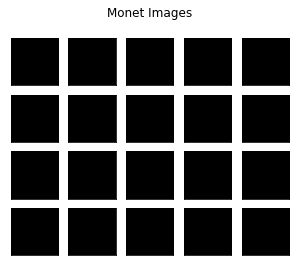

>63, 1/20, d=0.663, g=0.741
>63, 2/20, d=0.669, g=0.733
>63, 3/20, d=0.672, g=0.748
>63, 4/20, d=0.673, g=0.751
>63, 5/20, d=0.693, g=0.713
>63, 6/20, d=0.733, g=0.703
>63, 7/20, d=0.728, g=0.683
>63, 8/20, d=0.747, g=0.693
>63, 9/20, d=0.736, g=0.700
>63, 10/20, d=0.736, g=0.654
>63, 11/20, d=0.734, g=0.650
>63, 12/20, d=0.732, g=0.697
>63, 13/20, d=0.726, g=0.622
>63, 14/20, d=0.727, g=0.683
>63, 15/20, d=0.711, g=0.677
>63, 16/20, d=0.718, g=0.662
>63, 17/20, d=0.717, g=0.705
>63, 18/20, d=0.709, g=0.732
>63, 19/20, d=0.706, g=0.702
>63, 20/20, d=0.700, g=0.729
>Accuracy real: 40%, fake: 75%


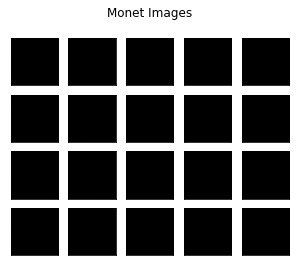

>64, 1/20, d=0.705, g=0.722
>64, 2/20, d=0.705, g=0.746
>64, 3/20, d=0.681, g=0.669
>64, 4/20, d=0.691, g=0.728
>64, 5/20, d=0.689, g=0.757
>64, 6/20, d=0.682, g=0.668
>64, 7/20, d=0.674, g=0.764
>64, 8/20, d=0.676, g=0.721
>64, 9/20, d=0.639, g=0.782
>64, 10/20, d=0.680, g=0.676
>64, 11/20, d=0.665, g=0.762
>64, 12/20, d=0.671, g=0.767
>64, 13/20, d=0.686, g=0.711
>64, 14/20, d=0.668, g=0.742
>64, 15/20, d=0.677, g=0.750
>64, 16/20, d=0.685, g=0.688
>64, 17/20, d=0.698, g=0.728
>64, 18/20, d=0.692, g=0.688
>64, 19/20, d=0.697, g=0.693
>64, 20/20, d=0.700, g=0.658
>Accuracy real: 89%, fake: 0%


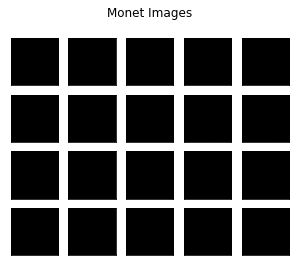

>65, 1/20, d=0.698, g=0.699
>65, 2/20, d=0.686, g=0.671
>65, 3/20, d=0.680, g=0.726
>65, 4/20, d=0.699, g=0.670
>65, 5/20, d=0.711, g=0.713
>65, 6/20, d=0.698, g=0.746
>65, 7/20, d=0.670, g=0.755
>65, 8/20, d=0.652, g=0.759
>65, 9/20, d=0.655, g=0.752
>65, 10/20, d=0.660, g=0.758
>65, 11/20, d=0.673, g=0.692
>65, 12/20, d=0.667, g=0.741
>65, 13/20, d=0.665, g=0.762
>65, 14/20, d=0.661, g=0.739
>65, 15/20, d=0.662, g=0.733
>65, 16/20, d=0.679, g=0.715
>65, 17/20, d=0.682, g=0.776
>65, 18/20, d=0.716, g=0.671
>65, 19/20, d=0.713, g=0.719
>65, 20/20, d=0.726, g=0.710
>Accuracy real: 15%, fake: 0%


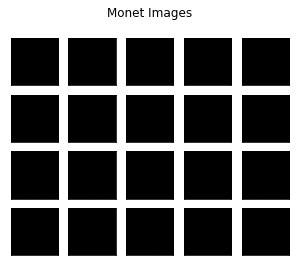

>66, 1/20, d=0.734, g=0.675
>66, 2/20, d=0.730, g=0.654
>66, 3/20, d=0.751, g=0.687
>66, 4/20, d=0.737, g=0.672
>66, 5/20, d=0.723, g=0.681
>66, 6/20, d=0.709, g=0.727
>66, 7/20, d=0.696, g=0.721
>66, 8/20, d=0.694, g=0.680
>66, 9/20, d=0.673, g=0.753
>66, 10/20, d=0.677, g=0.709
>66, 11/20, d=0.679, g=0.726
>66, 12/20, d=0.671, g=0.731
>66, 13/20, d=0.684, g=0.719
>66, 14/20, d=0.728, g=0.654
>66, 15/20, d=0.749, g=0.741
>66, 16/20, d=0.819, g=0.711
>66, 17/20, d=0.774, g=0.718
>66, 18/20, d=0.714, g=0.810
>66, 19/20, d=0.706, g=0.681
>66, 20/20, d=0.703, g=0.650
>Accuracy real: 100%, fake: 0%


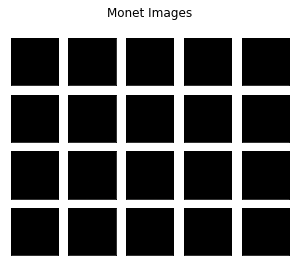

>67, 1/20, d=0.697, g=0.763
>67, 2/20, d=0.682, g=0.662
>67, 3/20, d=0.695, g=0.705
>67, 4/20, d=0.717, g=0.734
>67, 5/20, d=0.729, g=0.644
>67, 6/20, d=0.743, g=0.706
>67, 7/20, d=0.735, g=0.704
>67, 8/20, d=0.712, g=0.698
>67, 9/20, d=0.713, g=0.707
>67, 10/20, d=0.709, g=0.689
>67, 11/20, d=0.713, g=0.676
>67, 12/20, d=0.693, g=0.715
>67, 13/20, d=0.704, g=0.686
>67, 14/20, d=0.702, g=0.705
>67, 15/20, d=0.680, g=0.750
>67, 16/20, d=0.688, g=0.727
>67, 17/20, d=0.667, g=0.757
>67, 18/20, d=0.672, g=0.709
>67, 19/20, d=0.680, g=0.711
>67, 20/20, d=0.695, g=0.767
>Accuracy real: 1%, fake: 94%


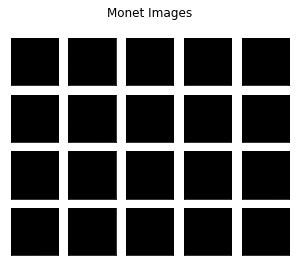

>68, 1/20, d=0.728, g=0.662
>68, 2/20, d=0.732, g=0.680
>68, 3/20, d=0.735, g=0.712
>68, 4/20, d=0.704, g=0.771
>68, 5/20, d=0.675, g=0.745
>68, 6/20, d=0.670, g=0.776
>68, 7/20, d=0.684, g=0.693
>68, 8/20, d=0.685, g=0.727
>68, 9/20, d=0.696, g=0.690
>68, 10/20, d=0.674, g=0.730
>68, 11/20, d=0.659, g=0.736
>68, 12/20, d=0.659, g=0.736
>68, 13/20, d=0.651, g=0.767
>68, 14/20, d=0.665, g=0.699
>68, 15/20, d=0.681, g=0.737
>68, 16/20, d=0.707, g=0.779
>68, 17/20, d=0.755, g=0.665
>68, 18/20, d=0.689, g=0.747
>68, 19/20, d=0.699, g=0.751
>68, 20/20, d=0.704, g=0.652
>Accuracy real: 100%, fake: 0%


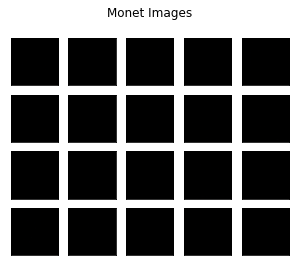

>69, 1/20, d=0.701, g=0.691
>69, 2/20, d=0.683, g=0.722
>69, 3/20, d=0.693, g=0.710
>69, 4/20, d=0.688, g=0.689
>69, 5/20, d=0.682, g=0.718
>69, 6/20, d=0.672, g=0.722
>69, 7/20, d=0.696, g=0.751
>69, 8/20, d=0.680, g=0.699
>69, 9/20, d=0.677, g=0.728
>69, 10/20, d=0.687, g=0.698
>69, 11/20, d=0.699, g=0.692
>69, 12/20, d=0.700, g=0.674
>69, 13/20, d=0.712, g=0.714
>69, 14/20, d=0.707, g=0.704
>69, 15/20, d=0.700, g=0.709
>69, 16/20, d=0.697, g=0.685
>69, 17/20, d=0.702, g=0.728
>69, 18/20, d=0.689, g=0.717
>69, 19/20, d=0.679, g=0.745
>69, 20/20, d=0.679, g=0.693
>Accuracy real: 100%, fake: 2%


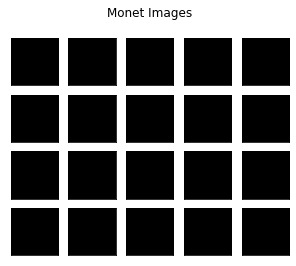

>70, 1/20, d=0.680, g=0.727
>70, 2/20, d=0.693, g=0.673
>70, 3/20, d=0.699, g=0.708
>70, 4/20, d=0.685, g=0.677
>70, 5/20, d=0.707, g=0.673
>70, 6/20, d=0.715, g=0.690
>70, 7/20, d=0.724, g=0.692
>70, 8/20, d=0.728, g=0.677
>70, 9/20, d=0.716, g=0.698
>70, 10/20, d=0.702, g=0.688
>70, 11/20, d=0.702, g=0.709
>70, 12/20, d=0.709, g=0.661
>70, 13/20, d=0.691, g=0.650
>70, 14/20, d=0.686, g=0.735
>70, 15/20, d=0.685, g=0.687
>70, 16/20, d=0.685, g=0.683
>70, 17/20, d=0.677, g=0.730
>70, 18/20, d=0.694, g=0.726
>70, 19/20, d=0.694, g=0.715
>70, 20/20, d=0.712, g=0.674
>Accuracy real: 57%, fake: 0%


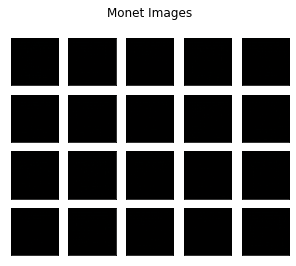

>71, 1/20, d=0.724, g=0.737
>71, 2/20, d=0.748, g=0.653
>71, 3/20, d=0.727, g=0.702
>71, 4/20, d=0.725, g=0.679
>71, 5/20, d=0.727, g=0.684
>71, 6/20, d=0.724, g=0.649
>71, 7/20, d=0.720, g=0.698
>71, 8/20, d=0.701, g=0.686
>71, 9/20, d=0.702, g=0.679
>71, 10/20, d=0.686, g=0.766
>71, 11/20, d=0.683, g=0.728
>71, 12/20, d=0.695, g=0.740
>71, 13/20, d=0.693, g=0.726
>71, 14/20, d=0.728, g=0.698
>71, 15/20, d=0.742, g=0.679
>71, 16/20, d=0.733, g=0.733
>71, 17/20, d=0.727, g=0.675
>71, 18/20, d=0.725, g=0.662
>71, 19/20, d=0.728, g=0.692
>71, 20/20, d=0.720, g=0.637
>Accuracy real: 99%, fake: 0%


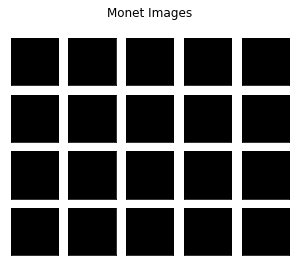

>72, 1/20, d=0.717, g=0.695
>72, 2/20, d=0.700, g=0.683
>72, 3/20, d=0.691, g=0.710
>72, 4/20, d=0.684, g=0.719
>72, 5/20, d=0.679, g=0.721
>72, 6/20, d=0.666, g=0.746
>72, 7/20, d=0.669, g=0.723
>72, 8/20, d=0.683, g=0.742
>72, 9/20, d=0.677, g=0.716
>72, 10/20, d=0.682, g=0.735
>72, 11/20, d=0.691, g=0.700
>72, 12/20, d=0.718, g=0.687
>72, 13/20, d=0.728, g=0.690
>72, 14/20, d=0.727, g=0.690
>72, 15/20, d=0.745, g=0.668
>72, 16/20, d=0.723, g=0.737
>72, 17/20, d=0.704, g=0.727
>72, 18/20, d=0.699, g=0.720
>72, 19/20, d=0.680, g=0.702
>72, 20/20, d=0.672, g=0.733
>Accuracy real: 97%, fake: 100%


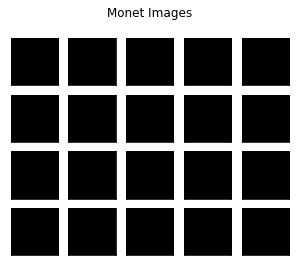

>73, 1/20, d=0.678, g=0.708
>73, 2/20, d=0.676, g=0.782
>73, 3/20, d=0.667, g=0.708
>73, 4/20, d=0.650, g=0.743
>73, 5/20, d=0.695, g=0.714
>73, 6/20, d=0.781, g=0.652
>73, 7/20, d=0.751, g=0.717
>73, 8/20, d=0.727, g=0.738
>73, 9/20, d=0.689, g=0.738
>73, 10/20, d=0.692, g=0.681
>73, 11/20, d=0.699, g=0.682
>73, 12/20, d=0.693, g=0.711
>73, 13/20, d=0.668, g=0.712
>73, 14/20, d=0.673, g=0.739
>73, 15/20, d=0.665, g=0.734
>73, 16/20, d=0.655, g=0.723
>73, 17/20, d=0.697, g=0.707
>73, 18/20, d=0.689, g=0.757
>73, 19/20, d=0.707, g=0.741
>73, 20/20, d=0.717, g=0.721
>Accuracy real: 80%, fake: 0%


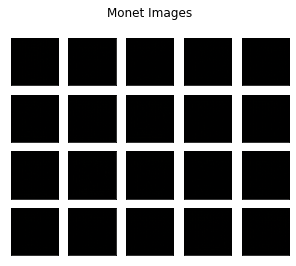

>74, 1/20, d=0.707, g=0.729
>74, 2/20, d=0.724, g=0.719
>74, 3/20, d=0.725, g=0.735
>74, 4/20, d=0.728, g=0.653
>74, 5/20, d=0.724, g=0.705
>74, 6/20, d=0.706, g=0.746
>74, 7/20, d=0.669, g=0.735
>74, 8/20, d=0.674, g=0.729
>74, 9/20, d=0.660, g=0.776
>74, 10/20, d=0.656, g=0.723
>74, 11/20, d=0.667, g=0.774
>74, 12/20, d=0.681, g=0.744
>74, 13/20, d=0.693, g=0.709
>74, 14/20, d=0.739, g=0.707
>74, 15/20, d=0.738, g=0.701
>74, 16/20, d=0.739, g=0.674
>74, 17/20, d=0.710, g=0.705
>74, 18/20, d=0.699, g=0.700
>74, 19/20, d=0.703, g=0.681
>74, 20/20, d=0.682, g=0.709
>Accuracy real: 88%, fake: 91%


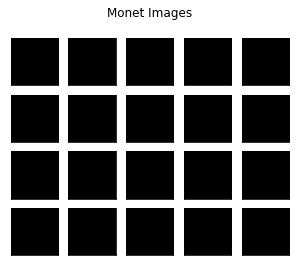

>75, 1/20, d=0.687, g=0.693
>75, 2/20, d=0.673, g=0.725
>75, 3/20, d=0.673, g=0.726
>75, 4/20, d=0.673, g=0.720
>75, 5/20, d=0.699, g=0.684
>75, 6/20, d=0.681, g=0.722
>75, 7/20, d=0.679, g=0.744
>75, 8/20, d=0.693, g=0.748
>75, 9/20, d=0.689, g=0.707
>75, 10/20, d=0.699, g=0.748
>75, 11/20, d=0.714, g=0.673
>75, 12/20, d=0.723, g=0.694
>75, 13/20, d=0.733, g=0.667
>75, 14/20, d=0.720, g=0.698
>75, 15/20, d=0.713, g=0.686
>75, 16/20, d=0.685, g=0.736
>75, 17/20, d=0.685, g=0.739
>75, 18/20, d=0.681, g=0.709
>75, 19/20, d=0.667, g=0.743
>75, 20/20, d=0.689, g=0.739
>Accuracy real: 88%, fake: 100%


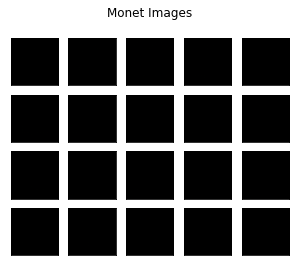

>76, 1/20, d=0.663, g=0.718
>76, 2/20, d=0.687, g=0.724
>76, 3/20, d=0.681, g=0.782
>76, 4/20, d=0.696, g=0.703
>76, 5/20, d=0.715, g=0.703
>76, 6/20, d=0.719, g=0.736
>76, 7/20, d=0.703, g=0.733
>76, 8/20, d=0.689, g=0.696
>76, 9/20, d=0.682, g=0.700
>76, 10/20, d=0.675, g=0.689
>76, 11/20, d=0.687, g=0.719
>76, 12/20, d=0.683, g=0.704
>76, 13/20, d=0.674, g=0.716
>76, 14/20, d=0.681, g=0.705
>76, 15/20, d=0.686, g=0.717
>76, 16/20, d=0.720, g=0.695
>76, 17/20, d=0.701, g=0.710
>76, 18/20, d=0.713, g=0.690
>76, 19/20, d=0.702, g=0.715
>76, 20/20, d=0.710, g=0.690
>Accuracy real: 38%, fake: 0%


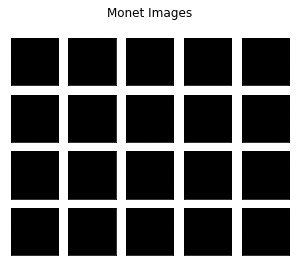

>77, 1/20, d=0.720, g=0.702
>77, 2/20, d=0.712, g=0.733
>77, 3/20, d=0.699, g=0.692
>77, 4/20, d=0.700, g=0.683
>77, 5/20, d=0.694, g=0.742
>77, 6/20, d=0.680, g=0.739
>77, 7/20, d=0.673, g=0.732
>77, 8/20, d=0.652, g=0.756
>77, 9/20, d=0.683, g=0.744
>77, 10/20, d=0.735, g=0.671
>77, 11/20, d=0.756, g=0.684
>77, 12/20, d=0.741, g=0.709
>77, 13/20, d=0.723, g=0.706
>77, 14/20, d=0.717, g=0.703
>77, 15/20, d=0.697, g=0.684
>77, 16/20, d=0.690, g=0.704
>77, 17/20, d=0.680, g=0.691
>77, 18/20, d=0.667, g=0.731
>77, 19/20, d=0.653, g=0.775
>77, 20/20, d=0.669, g=0.697
>Accuracy real: 97%, fake: 0%


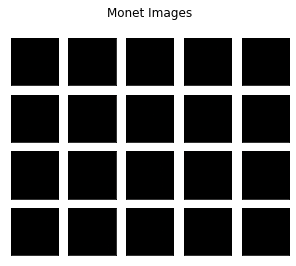

>78, 1/20, d=0.672, g=0.753
>78, 2/20, d=0.681, g=0.725
>78, 3/20, d=0.690, g=0.705
>78, 4/20, d=0.697, g=0.742
>78, 5/20, d=0.709, g=0.700
>78, 6/20, d=0.705, g=0.715
>78, 7/20, d=0.711, g=0.686
>78, 8/20, d=0.712, g=0.667
>78, 9/20, d=0.718, g=0.667
>78, 10/20, d=0.712, g=0.729
>78, 11/20, d=0.700, g=0.697
>78, 12/20, d=0.703, g=0.700
>78, 13/20, d=0.689, g=0.721
>78, 14/20, d=0.673, g=0.724
>78, 15/20, d=0.665, g=0.742
>78, 16/20, d=0.668, g=0.744
>78, 17/20, d=0.668, g=0.748
>78, 18/20, d=0.666, g=0.740
>78, 19/20, d=0.685, g=0.704
>78, 20/20, d=0.709, g=0.681
>Accuracy real: 67%, fake: 2%


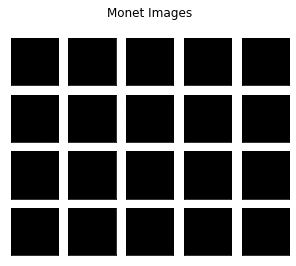

>79, 1/20, d=0.687, g=0.701
>79, 2/20, d=0.696, g=0.725
>79, 3/20, d=0.704, g=0.661
>79, 4/20, d=0.704, g=0.710
>79, 5/20, d=0.695, g=0.715
>79, 6/20, d=0.689, g=0.705
>79, 7/20, d=0.676, g=0.706
>79, 8/20, d=0.698, g=0.686
>79, 9/20, d=0.689, g=0.730
>79, 10/20, d=0.671, g=0.690
>79, 11/20, d=0.703, g=0.682
>79, 12/20, d=0.695, g=0.722
>79, 13/20, d=0.696, g=0.746
>79, 14/20, d=0.680, g=0.725
>79, 15/20, d=0.695, g=0.711
>79, 16/20, d=0.716, g=0.724
>79, 17/20, d=0.707, g=0.690
>79, 18/20, d=0.713, g=0.698
>79, 19/20, d=0.735, g=0.691
>79, 20/20, d=0.754, g=0.661
>Accuracy real: 0%, fake: 0%


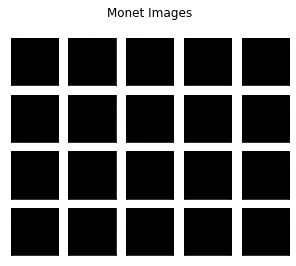

>80, 1/20, d=0.758, g=0.696
>80, 2/20, d=0.744, g=0.713
>80, 3/20, d=0.711, g=0.746
>80, 4/20, d=0.681, g=0.750
>80, 5/20, d=0.710, g=0.659
>80, 6/20, d=0.691, g=0.747
>80, 7/20, d=0.675, g=0.734
>80, 8/20, d=0.677, g=0.708
>80, 9/20, d=0.677, g=0.746
>80, 10/20, d=0.677, g=0.776
>80, 11/20, d=0.685, g=0.675
>80, 12/20, d=0.726, g=0.717
>80, 13/20, d=0.760, g=0.718
>80, 14/20, d=0.737, g=0.698
>80, 15/20, d=0.739, g=0.689
>80, 16/20, d=0.715, g=0.686
>80, 17/20, d=0.709, g=0.679
>80, 18/20, d=0.711, g=0.661
>80, 19/20, d=0.723, g=0.683
>80, 20/20, d=0.680, g=0.716
>Accuracy real: 67%, fake: 82%


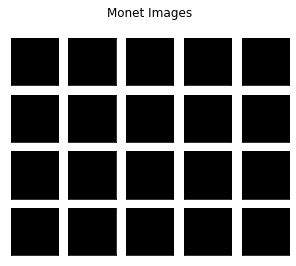

>81, 1/20, d=0.696, g=0.683
>81, 2/20, d=0.686, g=0.697
>81, 3/20, d=0.674, g=0.760
>81, 4/20, d=0.661, g=0.735
>81, 5/20, d=0.669, g=0.716
>81, 6/20, d=0.677, g=0.717
>81, 7/20, d=0.663, g=0.730
>81, 8/20, d=0.674, g=0.726
>81, 9/20, d=0.691, g=0.725
>81, 10/20, d=0.695, g=0.690
>81, 11/20, d=0.732, g=0.722
>81, 12/20, d=0.736, g=0.647
>81, 13/20, d=0.747, g=0.736
>81, 14/20, d=0.749, g=0.716
>81, 15/20, d=0.703, g=0.707
>81, 16/20, d=0.671, g=0.775
>81, 17/20, d=0.668, g=0.739
>81, 18/20, d=0.668, g=0.719
>81, 19/20, d=0.681, g=0.689
>81, 20/20, d=0.671, g=0.756
>Accuracy real: 84%, fake: 100%


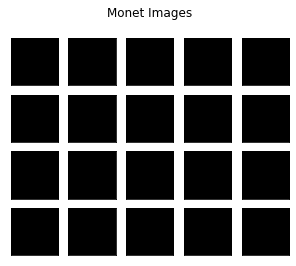

>82, 1/20, d=0.678, g=0.722
>82, 2/20, d=0.673, g=0.722
>82, 3/20, d=0.671, g=0.762
>82, 4/20, d=0.682, g=0.761
>82, 5/20, d=0.743, g=0.695
>82, 6/20, d=0.777, g=0.725
>82, 7/20, d=0.726, g=0.779
>82, 8/20, d=0.698, g=0.734
>82, 9/20, d=0.685, g=0.671
>82, 10/20, d=0.688, g=0.753
>82, 11/20, d=0.676, g=0.705
>82, 12/20, d=0.673, g=0.737
>82, 13/20, d=0.682, g=0.723
>82, 14/20, d=0.724, g=0.684
>82, 15/20, d=0.731, g=0.714
>82, 16/20, d=0.705, g=0.680
>82, 17/20, d=0.720, g=0.746
>82, 18/20, d=0.711, g=0.683
>82, 19/20, d=0.715, g=0.690
>82, 20/20, d=0.703, g=0.722
>Accuracy real: 79%, fake: 85%


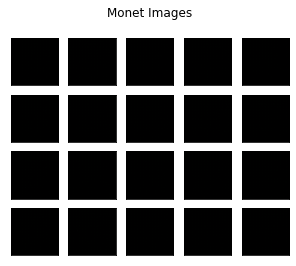

>83, 1/20, d=0.675, g=0.730
>83, 2/20, d=0.675, g=0.712
>83, 3/20, d=0.660, g=0.752
>83, 4/20, d=0.682, g=0.710
>83, 5/20, d=0.674, g=0.738
>83, 6/20, d=0.700, g=0.720
>83, 7/20, d=0.687, g=0.730
>83, 8/20, d=0.707, g=0.691
>83, 9/20, d=0.706, g=0.691
>83, 10/20, d=0.715, g=0.710
>83, 11/20, d=0.711, g=0.665
>83, 12/20, d=0.711, g=0.682
>83, 13/20, d=0.726, g=0.703
>83, 14/20, d=0.700, g=0.686
>83, 15/20, d=0.696, g=0.684
>83, 16/20, d=0.697, g=0.723
>83, 17/20, d=0.678, g=0.703
>83, 18/20, d=0.668, g=0.755
>83, 19/20, d=0.669, g=0.740
>83, 20/20, d=0.674, g=0.693
>Accuracy real: 90%, fake: 6%


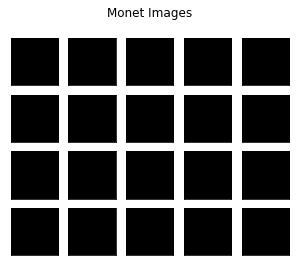

>84, 1/20, d=0.683, g=0.775
>84, 2/20, d=0.698, g=0.739
>84, 3/20, d=0.770, g=0.681
>84, 4/20, d=0.722, g=0.728
>84, 5/20, d=0.743, g=0.732
>84, 6/20, d=0.743, g=0.662
>84, 7/20, d=0.733, g=0.665
>84, 8/20, d=0.715, g=0.720
>84, 9/20, d=0.684, g=0.745
>84, 10/20, d=0.683, g=0.698
>84, 11/20, d=0.698, g=0.718
>84, 12/20, d=0.668, g=0.748
>84, 13/20, d=0.677, g=0.693
>84, 14/20, d=0.699, g=0.705
>84, 15/20, d=0.710, g=0.720
>84, 16/20, d=0.728, g=0.663
>84, 17/20, d=0.734, g=0.697
>84, 18/20, d=0.714, g=0.715
>84, 19/20, d=0.723, g=0.641
>84, 20/20, d=0.724, g=0.652
>Accuracy real: 85%, fake: 0%


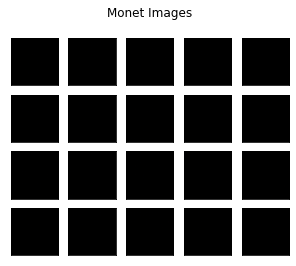

>85, 1/20, d=0.727, g=0.708
>85, 2/20, d=0.712, g=0.666
>85, 3/20, d=0.697, g=0.696
>85, 4/20, d=0.691, g=0.697
>85, 5/20, d=0.679, g=0.723
>85, 6/20, d=0.665, g=0.748
>85, 7/20, d=0.668, g=0.723
>85, 8/20, d=0.672, g=0.725
>85, 9/20, d=0.666, g=0.761
>85, 10/20, d=0.697, g=0.699
>85, 11/20, d=0.727, g=0.671
>85, 12/20, d=0.704, g=0.713
>85, 13/20, d=0.705, g=0.712
>85, 14/20, d=0.704, g=0.726
>85, 15/20, d=0.705, g=0.677
>85, 16/20, d=0.705, g=0.709
>85, 17/20, d=0.705, g=0.729
>85, 18/20, d=0.688, g=0.717
>85, 19/20, d=0.680, g=0.720
>85, 20/20, d=0.676, g=0.756
>Accuracy real: 93%, fake: 99%


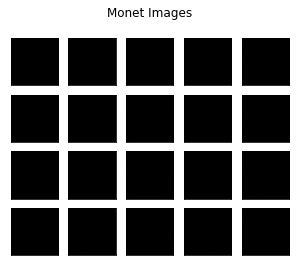

>86, 1/20, d=0.669, g=0.742
>86, 2/20, d=0.662, g=0.739
>86, 3/20, d=0.677, g=0.705
>86, 4/20, d=0.663, g=0.749
>86, 5/20, d=0.694, g=0.709
>86, 6/20, d=0.710, g=0.698
>86, 7/20, d=0.706, g=0.716
>86, 8/20, d=0.709, g=0.673
>86, 9/20, d=0.688, g=0.746
>86, 10/20, d=0.689, g=0.638
>86, 11/20, d=0.693, g=0.766
>86, 12/20, d=0.688, g=0.667
>86, 13/20, d=0.667, g=0.773
>86, 14/20, d=0.674, g=0.693
>86, 15/20, d=0.668, g=0.723
>86, 16/20, d=0.666, g=0.740
>86, 17/20, d=0.669, g=0.747
>86, 18/20, d=0.675, g=0.697
>86, 19/20, d=0.669, g=0.758
>86, 20/20, d=0.680, g=0.693
>Accuracy real: 94%, fake: 1%


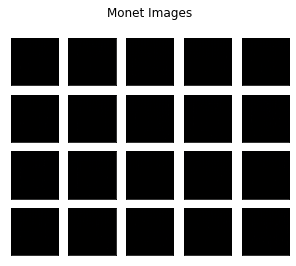

>87, 1/20, d=0.680, g=0.748
>87, 2/20, d=0.691, g=0.699
>87, 3/20, d=0.703, g=0.744
>87, 4/20, d=0.718, g=0.676
>87, 5/20, d=0.729, g=0.723
>87, 6/20, d=0.724, g=0.668
>87, 7/20, d=0.746, g=0.683
>87, 8/20, d=0.711, g=0.745
>87, 9/20, d=0.725, g=0.608
>87, 10/20, d=0.696, g=0.872
>87, 11/20, d=0.699, g=0.601
>87, 12/20, d=0.693, g=0.760
>87, 13/20, d=0.675, g=0.759
>87, 14/20, d=0.699, g=0.653
>87, 15/20, d=0.688, g=0.773
>87, 16/20, d=0.723, g=0.696
>87, 17/20, d=0.772, g=0.695
>87, 18/20, d=0.830, g=0.668
>87, 19/20, d=0.774, g=0.736
>87, 20/20, d=0.747, g=0.719
>Accuracy real: 0%, fake: 41%


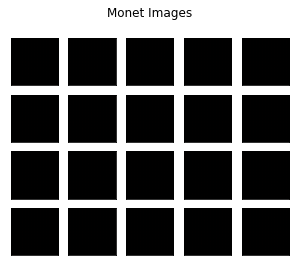

>88, 1/20, d=0.728, g=0.665
>88, 2/20, d=0.711, g=0.698
>88, 3/20, d=0.709, g=0.670
>88, 4/20, d=0.684, g=0.732
>88, 5/20, d=0.667, g=0.759
>88, 6/20, d=0.658, g=0.738
>88, 7/20, d=0.635, g=0.788
>88, 8/20, d=0.637, g=0.793
>88, 9/20, d=0.627, g=0.775
>88, 10/20, d=0.680, g=0.734
>88, 11/20, d=0.705, g=0.798
>88, 12/20, d=0.706, g=0.728
>88, 13/20, d=0.711, g=0.756
>88, 14/20, d=0.697, g=0.747
>88, 15/20, d=0.709, g=0.691
>88, 16/20, d=0.723, g=0.663
>88, 17/20, d=0.711, g=0.723
>88, 18/20, d=0.701, g=0.746
>88, 19/20, d=0.679, g=0.723
>88, 20/20, d=0.664, g=0.796
>Accuracy real: 75%, fake: 100%


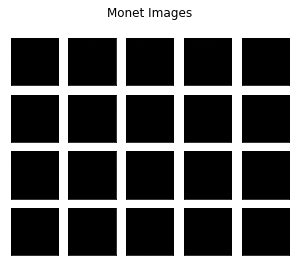

>89, 1/20, d=0.661, g=0.716
>89, 2/20, d=0.657, g=0.755
>89, 3/20, d=0.661, g=0.756
>89, 4/20, d=0.660, g=0.726
>89, 5/20, d=0.652, g=0.737
>89, 6/20, d=0.657, g=0.775
>89, 7/20, d=0.678, g=0.705
>89, 8/20, d=0.720, g=0.672
>89, 9/20, d=0.723, g=0.732
>89, 10/20, d=0.712, g=0.679
>89, 11/20, d=0.750, g=0.681
>89, 12/20, d=0.729, g=0.718
>89, 13/20, d=0.714, g=0.680
>89, 14/20, d=0.721, g=0.666
>89, 15/20, d=0.713, g=0.688
>89, 16/20, d=0.713, g=0.683
>89, 17/20, d=0.710, g=0.711
>89, 18/20, d=0.693, g=0.767
>89, 19/20, d=0.697, g=0.704
>89, 20/20, d=0.709, g=0.702
>Accuracy real: 27%, fake: 0%


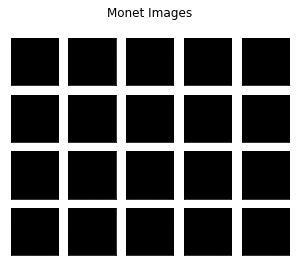

>90, 1/20, d=0.721, g=0.736
>90, 2/20, d=0.747, g=0.738
>90, 3/20, d=0.724, g=0.711
>90, 4/20, d=0.714, g=0.716
>90, 5/20, d=0.686, g=0.759
>90, 6/20, d=0.674, g=0.728
>90, 7/20, d=0.669, g=0.706
>90, 8/20, d=0.658, g=0.748
>90, 9/20, d=0.660, g=0.733
>90, 10/20, d=0.653, g=0.778
>90, 11/20, d=0.656, g=0.749
>90, 12/20, d=0.667, g=0.802
>90, 13/20, d=0.697, g=0.719
>90, 14/20, d=0.742, g=0.695
>90, 15/20, d=0.742, g=0.678
>90, 16/20, d=0.740, g=0.721
>90, 17/20, d=0.744, g=0.631
>90, 18/20, d=0.752, g=0.607
>90, 19/20, d=0.750, g=0.693
>90, 20/20, d=0.746, g=0.619
>Accuracy real: 97%, fake: 0%


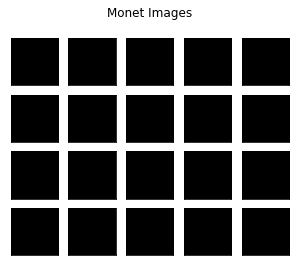

>91, 1/20, d=0.714, g=0.677
>91, 2/20, d=0.712, g=0.679
>91, 3/20, d=0.696, g=0.696
>91, 4/20, d=0.692, g=0.713
>91, 5/20, d=0.680, g=0.715
>91, 6/20, d=0.676, g=0.696
>91, 7/20, d=0.669, g=0.710
>91, 8/20, d=0.672, g=0.734
>91, 9/20, d=0.687, g=0.723
>91, 10/20, d=0.691, g=0.712
>91, 11/20, d=0.709, g=0.685
>91, 12/20, d=0.732, g=0.736
>91, 13/20, d=0.751, g=0.700
>91, 14/20, d=0.747, g=0.737
>91, 15/20, d=0.721, g=0.766
>91, 16/20, d=0.713, g=0.732
>91, 17/20, d=0.723, g=0.639
>91, 18/20, d=0.728, g=0.690
>91, 19/20, d=0.714, g=0.708
>91, 20/20, d=0.714, g=0.683
>Accuracy real: 95%, fake: 0%


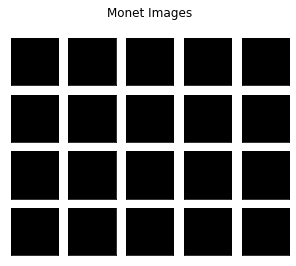

>92, 1/20, d=0.682, g=0.720
>92, 2/20, d=0.700, g=0.716
>92, 3/20, d=0.715, g=0.708
>92, 4/20, d=0.761, g=0.686
>92, 5/20, d=0.751, g=0.734
>92, 6/20, d=0.736, g=0.710
>92, 7/20, d=0.714, g=0.722
>92, 8/20, d=0.687, g=0.746
>92, 9/20, d=0.673, g=0.702
>92, 10/20, d=0.668, g=0.707
>92, 11/20, d=0.659, g=0.770
>92, 12/20, d=0.662, g=0.755
>92, 13/20, d=0.669, g=0.726
>92, 14/20, d=0.656, g=0.765
>92, 15/20, d=0.673, g=0.746
>92, 16/20, d=0.690, g=0.730
>92, 17/20, d=0.687, g=0.697
>92, 18/20, d=0.702, g=0.727
>92, 19/20, d=0.724, g=0.676
>92, 20/20, d=0.721, g=0.662
>Accuracy real: 60%, fake: 0%


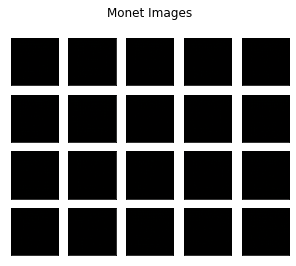

>93, 1/20, d=0.716, g=0.714
>93, 2/20, d=0.704, g=0.706
>93, 3/20, d=0.693, g=0.706
>93, 4/20, d=0.681, g=0.721
>93, 5/20, d=0.682, g=0.718
>93, 6/20, d=0.692, g=0.720
>93, 7/20, d=0.679, g=0.688
>93, 8/20, d=0.676, g=0.741
>93, 9/20, d=0.694, g=0.709
>93, 10/20, d=0.670, g=0.726
>93, 11/20, d=0.684, g=0.705
>93, 12/20, d=0.668, g=0.736
>93, 13/20, d=0.667, g=0.715
>93, 14/20, d=0.676, g=0.710
>93, 15/20, d=0.686, g=0.714
>93, 16/20, d=0.694, g=0.688
>93, 17/20, d=0.705, g=0.731
>93, 18/20, d=0.708, g=0.688
>93, 19/20, d=0.714, g=0.688
>93, 20/20, d=0.730, g=0.688
>Accuracy real: 14%, fake: 0%


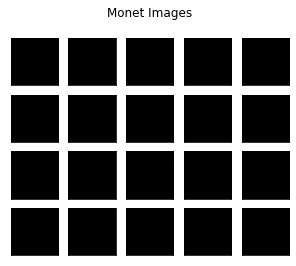

>94, 1/20, d=0.723, g=0.707
>94, 2/20, d=0.724, g=0.688
>94, 3/20, d=0.719, g=0.683
>94, 4/20, d=0.711, g=0.714
>94, 5/20, d=0.712, g=0.665
>94, 6/20, d=0.720, g=0.628
>94, 7/20, d=0.714, g=0.704
>94, 8/20, d=0.704, g=0.709
>94, 9/20, d=0.704, g=0.676
>94, 10/20, d=0.700, g=0.717
>94, 11/20, d=0.702, g=0.703
>94, 12/20, d=0.709, g=0.713
>94, 13/20, d=0.728, g=0.709
>94, 14/20, d=0.734, g=0.728
>94, 15/20, d=0.702, g=0.735
>94, 16/20, d=0.692, g=0.746
>94, 17/20, d=0.686, g=0.699
>94, 18/20, d=0.685, g=0.731
>94, 19/20, d=0.674, g=0.758
>94, 20/20, d=0.673, g=0.733
>Accuracy real: 68%, fake: 94%


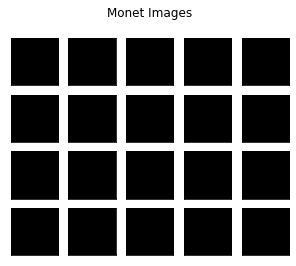

>95, 1/20, d=0.680, g=0.706
>95, 2/20, d=0.688, g=0.762
>95, 3/20, d=0.706, g=0.711
>95, 4/20, d=0.732, g=0.664
>95, 5/20, d=0.736, g=0.680
>95, 6/20, d=0.734, g=0.688
>95, 7/20, d=0.736, g=0.672
>95, 8/20, d=0.720, g=0.656
>95, 9/20, d=0.719, g=0.654
>95, 10/20, d=0.712, g=0.673
>95, 11/20, d=0.715, g=0.691
>95, 12/20, d=0.708, g=0.673
>95, 13/20, d=0.710, g=0.671
>95, 14/20, d=0.699, g=0.707
>95, 15/20, d=0.707, g=0.686
>95, 16/20, d=0.700, g=0.679
>95, 17/20, d=0.701, g=0.684
>95, 18/20, d=0.708, g=0.709
>95, 19/20, d=0.707, g=0.682
>95, 20/20, d=0.714, g=0.670
>Accuracy real: 17%, fake: 0%


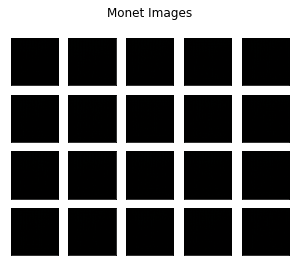

>96, 1/20, d=0.728, g=0.678
>96, 2/20, d=0.721, g=0.723
>96, 3/20, d=0.708, g=0.718
>96, 4/20, d=0.681, g=0.754
>96, 5/20, d=0.674, g=0.789
>96, 6/20, d=0.699, g=0.694
>96, 7/20, d=0.679, g=0.714
>96, 8/20, d=0.700, g=0.697
>96, 9/20, d=0.700, g=0.683
>96, 10/20, d=0.704, g=0.688
>96, 11/20, d=0.707, g=0.697
>96, 12/20, d=0.722, g=0.665
>96, 13/20, d=0.770, g=0.655
>96, 14/20, d=0.784, g=0.662
>96, 15/20, d=0.754, g=0.714
>96, 16/20, d=0.708, g=0.715
>96, 17/20, d=0.698, g=0.718
>96, 18/20, d=0.692, g=0.699
>96, 19/20, d=0.686, g=0.704
>96, 20/20, d=0.677, g=0.726
>Accuracy real: 94%, fake: 99%


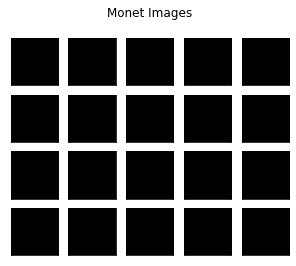

>97, 1/20, d=0.677, g=0.723
>97, 2/20, d=0.671, g=0.734
>97, 3/20, d=0.676, g=0.705
>97, 4/20, d=0.687, g=0.721
>97, 5/20, d=0.712, g=0.703
>97, 6/20, d=0.710, g=0.693
>97, 7/20, d=0.744, g=0.692
>97, 8/20, d=0.760, g=0.691
>97, 9/20, d=0.742, g=0.686
>97, 10/20, d=0.726, g=0.752
>97, 11/20, d=0.713, g=0.688
>97, 12/20, d=0.699, g=0.674
>97, 13/20, d=0.690, g=0.699
>97, 14/20, d=0.693, g=0.690
>97, 15/20, d=0.677, g=0.709
>97, 16/20, d=0.687, g=0.700
>97, 17/20, d=0.695, g=0.697
>97, 18/20, d=0.699, g=0.697
>97, 19/20, d=0.687, g=0.708
>97, 20/20, d=0.717, g=0.681
>Accuracy real: 36%, fake: 0%


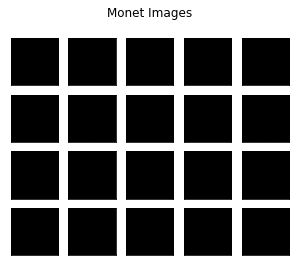

>98, 1/20, d=0.724, g=0.688
>98, 2/20, d=0.710, g=0.730
>98, 3/20, d=0.693, g=0.718
>98, 4/20, d=0.685, g=0.716
>98, 5/20, d=0.680, g=0.716
>98, 6/20, d=0.684, g=0.719
>98, 7/20, d=0.677, g=0.719
>98, 8/20, d=0.690, g=0.697
>98, 9/20, d=0.696, g=0.699
>98, 10/20, d=0.690, g=0.708
>98, 11/20, d=0.673, g=0.706
>98, 12/20, d=0.667, g=0.706
>98, 13/20, d=0.709, g=0.695
>98, 14/20, d=0.724, g=0.710
>98, 15/20, d=0.736, g=0.707
>98, 16/20, d=0.710, g=0.704
>98, 17/20, d=0.713, g=0.710
>98, 18/20, d=0.694, g=0.712
>98, 19/20, d=0.705, g=0.691
>98, 20/20, d=0.694, g=0.672
>Accuracy real: 83%, fake: 0%


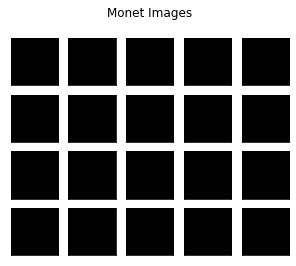

>99, 1/20, d=0.690, g=0.722
>99, 2/20, d=0.687, g=0.712
>99, 3/20, d=0.693, g=0.719
>99, 4/20, d=0.683, g=0.698
>99, 5/20, d=0.675, g=0.712
>99, 6/20, d=0.682, g=0.702
>99, 7/20, d=0.672, g=0.713
>99, 8/20, d=0.684, g=0.733
>99, 9/20, d=0.668, g=0.703
>99, 10/20, d=0.675, g=0.717
>99, 11/20, d=0.681, g=0.739
>99, 12/20, d=0.674, g=0.714
>99, 13/20, d=0.674, g=0.717
>99, 14/20, d=0.683, g=0.727
>99, 15/20, d=0.681, g=0.741
>99, 16/20, d=0.667, g=0.726
>99, 17/20, d=0.687, g=0.709
>99, 18/20, d=0.686, g=0.727
>99, 19/20, d=0.673, g=0.695
>99, 20/20, d=0.679, g=0.699
>Accuracy real: 83%, fake: 3%


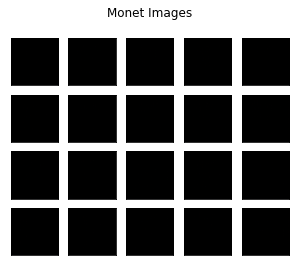

>100, 1/20, d=0.696, g=0.705
>100, 2/20, d=0.688, g=0.723
>100, 3/20, d=0.712, g=0.660
>100, 4/20, d=0.713, g=0.678
>100, 5/20, d=0.712, g=0.703
>100, 6/20, d=0.712, g=0.692
>100, 7/20, d=0.706, g=0.691
>100, 8/20, d=0.724, g=0.662
>100, 9/20, d=0.721, g=0.663
>100, 10/20, d=0.717, g=0.684
>100, 11/20, d=0.711, g=0.673
>100, 12/20, d=0.710, g=0.698
>100, 13/20, d=0.709, g=0.691
>100, 14/20, d=0.690, g=0.692
>100, 15/20, d=0.690, g=0.694
>100, 16/20, d=0.690, g=0.708
>100, 17/20, d=0.699, g=0.706
>100, 18/20, d=0.689, g=0.715
>100, 19/20, d=0.681, g=0.715
>100, 20/20, d=0.676, g=0.711
>Accuracy real: 91%, fake: 34%


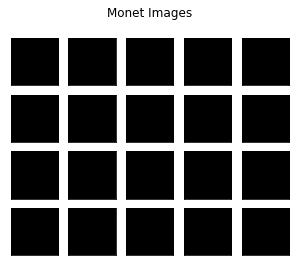

In [10]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
print('DISCRIMINATOR')
d_model.summary()
# create the generator
g_model = define_generator(latent_dim)
print('GENERATOR')
g_model.summary()
# create the gan
gan_model = define_gan(g_model, d_model)
print('GAN')
gan_model.summary()
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)